# PCA with Scikit-learn on Real Datasets

**Author**: Nelson Masbayi

---

In this notebook, I apply PCA to real-world datasets using scikit-learn, starting with the classic Iris dataset then exploring high-dimensional datasets.

## Table of Contents

1. [Iris Dataset Analysis](#iris-dataset-analysis)
2. [Component Interpretation](#component-interpretation)
3. [Scree Plot Analysis](#scree-plot-analysis)
4. [High-Dimensional Dataset Analysis](#high-dimensional-dataset-analysis)
5. [Practical Insights](#practical-insights)

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, fetch_olivetti_faces, load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add src directory to the path for our utilities
sys.path.append('../src')
from visualization_utils import plot_2d_pca_results, compare_pca_implementations

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 12

# Set random seed
np.random.seed(42)

print("✅ All imports successful!")
print(f"Scikit-learn PCA ready for real-world data analysis")

✅ All imports successful!
Scikit-learn PCA ready for real-world data analysis


## Iris Dataset Analysis

The Iris dataset is perfect for PCA analysis as it has:
- 4 continuous features (sepal/petal length/width)
- 3 well-separated classes
- Known biological relationships between features
- Small size for easy interpretation

In [2]:
# Load the Iris dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

print("Iris Dataset Information:")
print(f"Data shape: {X_iris.shape}")
print(f"Features: {feature_names}")
print(f"Classes: {target_names}")
print(f"Class distribution: {np.bincount(y_iris)}")

# Display basic statistics
iris_df = pd.DataFrame(X_iris, columns=feature_names)
iris_df['species'] = [target_names[i] for i in y_iris]

print("\nBasic Statistics:")
print(iris_df.describe())

# Check for missing values
print(f"\nMissing values: {iris_df.isnull().sum().sum()}")
print(f"Data types: {iris_df.dtypes.unique()}")

Iris Dataset Information:
Data shape: (150, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: ['setosa' 'versicolor' 'virginica']
Class distribution: [50 50 50]

Basic Statistics:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)  
count        150.000000  
mean           1.199333  
std            0.762238  
min            0.100000  
25%            0.300000  
50%            1.300000

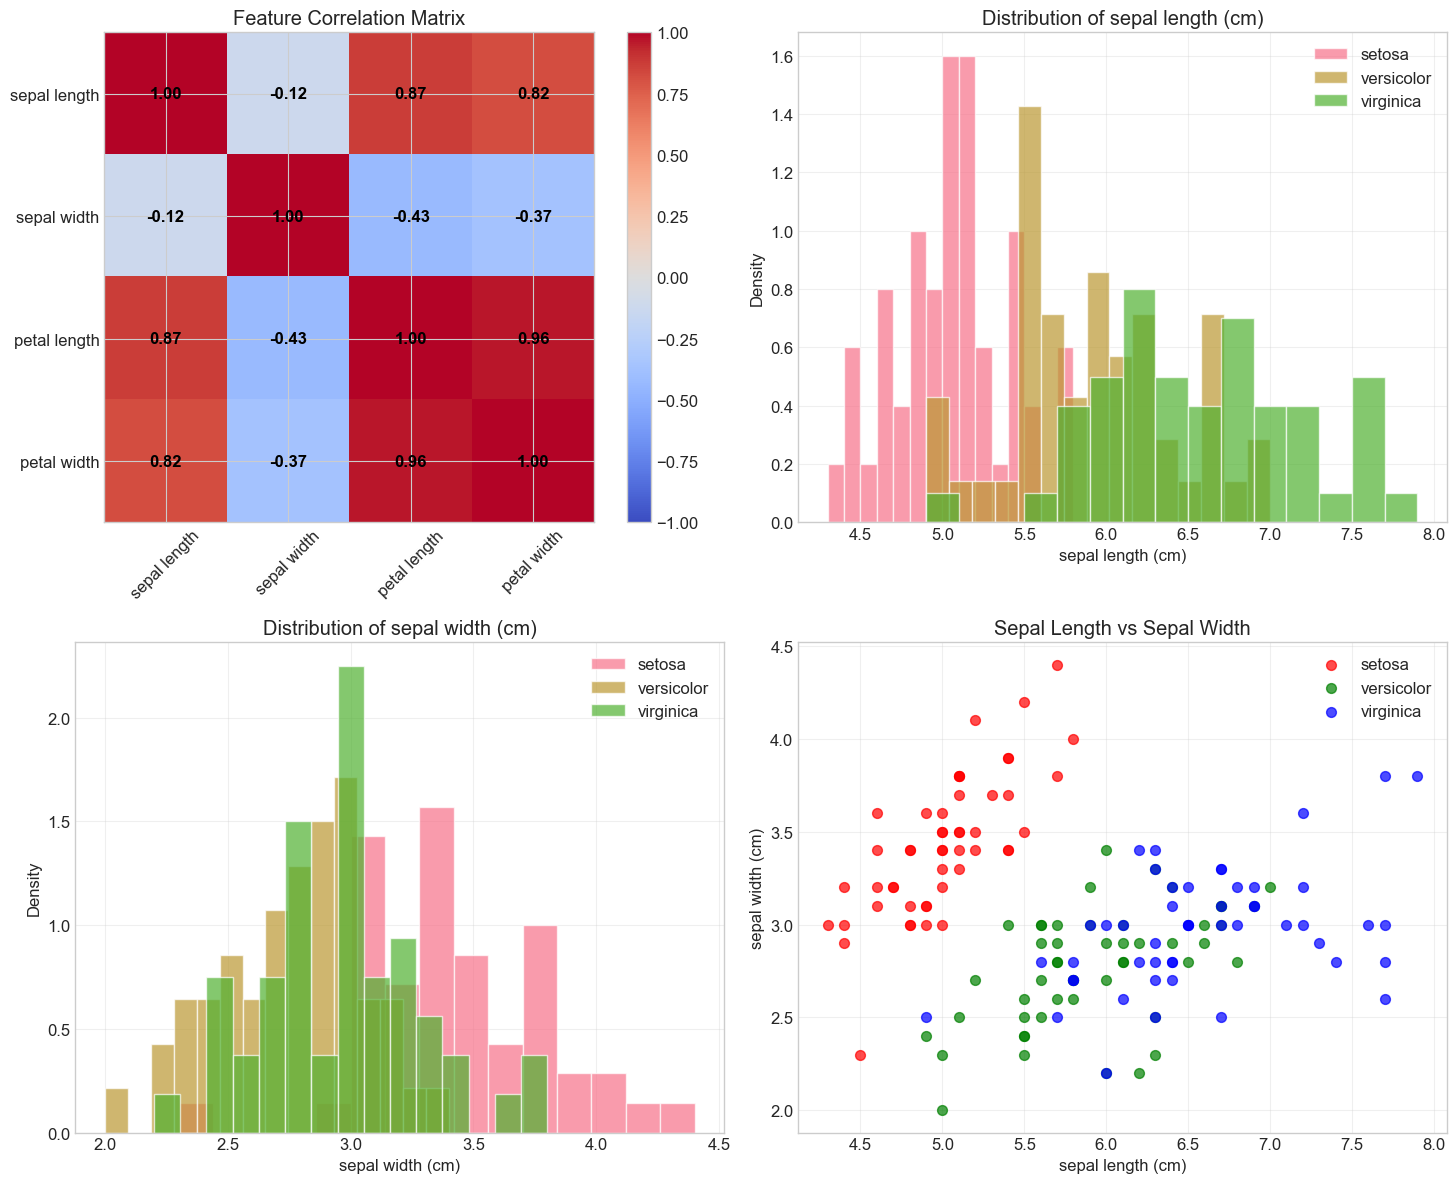

Key Observations:
• Highest correlation: 0.963
• Features show clear class separations
• Petal measurements likely more discriminative than sepal measurements


In [3]:
# Explore the data with pairwise plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Raw data correlation matrix
correlation_matrix = np.corrcoef(X_iris.T)
im = axes[0, 0].imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
axes[0, 0].set_title('Feature Correlation Matrix')
axes[0, 0].set_xticks(range(len(feature_names)))
axes[0, 0].set_yticks(range(len(feature_names)))
axes[0, 0].set_xticklabels([name.replace(' (cm)', '') for name in feature_names], rotation=45)
axes[0, 0].set_yticklabels([name.replace(' (cm)', '') for name in feature_names])

# Add correlation values
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        text = axes[0, 0].text(j, i, f'{correlation_matrix[i, j]:.2f}',
                             ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=axes[0, 0])

# Feature distributions by class
for idx, feature_idx in enumerate([0, 1]):  # First two features
    ax = axes[0, 1] if idx == 0 else axes[1, 0]

    for class_idx, class_name in enumerate(target_names):
        class_data = X_iris[y_iris == class_idx, feature_idx]
        ax.hist(class_data, bins=15, alpha=0.7, label=class_name, density=True)

    ax.set_title(f'Distribution of {feature_names[feature_idx]}')
    ax.set_xlabel(feature_names[feature_idx])
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Scatter plot of first two features
colors = ['red', 'green', 'blue']
for class_idx, (class_name, color) in enumerate(zip(target_names, colors)):
    class_mask = y_iris == class_idx
    axes[1, 1].scatter(X_iris[class_mask, 0], X_iris[class_mask, 1],
                      c=color, label=class_name, alpha=0.7, s=50)

axes[1, 1].set_title('Sepal Length vs Sepal Width')
axes[1, 1].set_xlabel(feature_names[0])
axes[1, 1].set_ylabel(feature_names[1])
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key Observations:")
print(f"• Highest correlation: {np.max(correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)]):.3f}")
print(f"• Features show clear class separations")
print(f"• Petal measurements likely more discriminative than sepal measurements")

### Data Standardization Decision

Analyze the importance of data standardization:

Feature Scale Analysis:

Feature Means:
sepal length (cm): 5.84
sepal width (cm): 3.06
petal length (cm): 3.76
petal width (cm): 1.20

Feature Standard Deviations:
sepal length (cm): 0.83
sepal width (cm): 0.43
petal length (cm): 1.76
petal width (cm): 0.76

Feature Ranges:
sepal length (cm): [4.3, 7.9]
sepal width (cm): [2.0, 4.4]
petal length (cm): [1.0, 6.9]
petal width (cm): [0.1, 2.5]


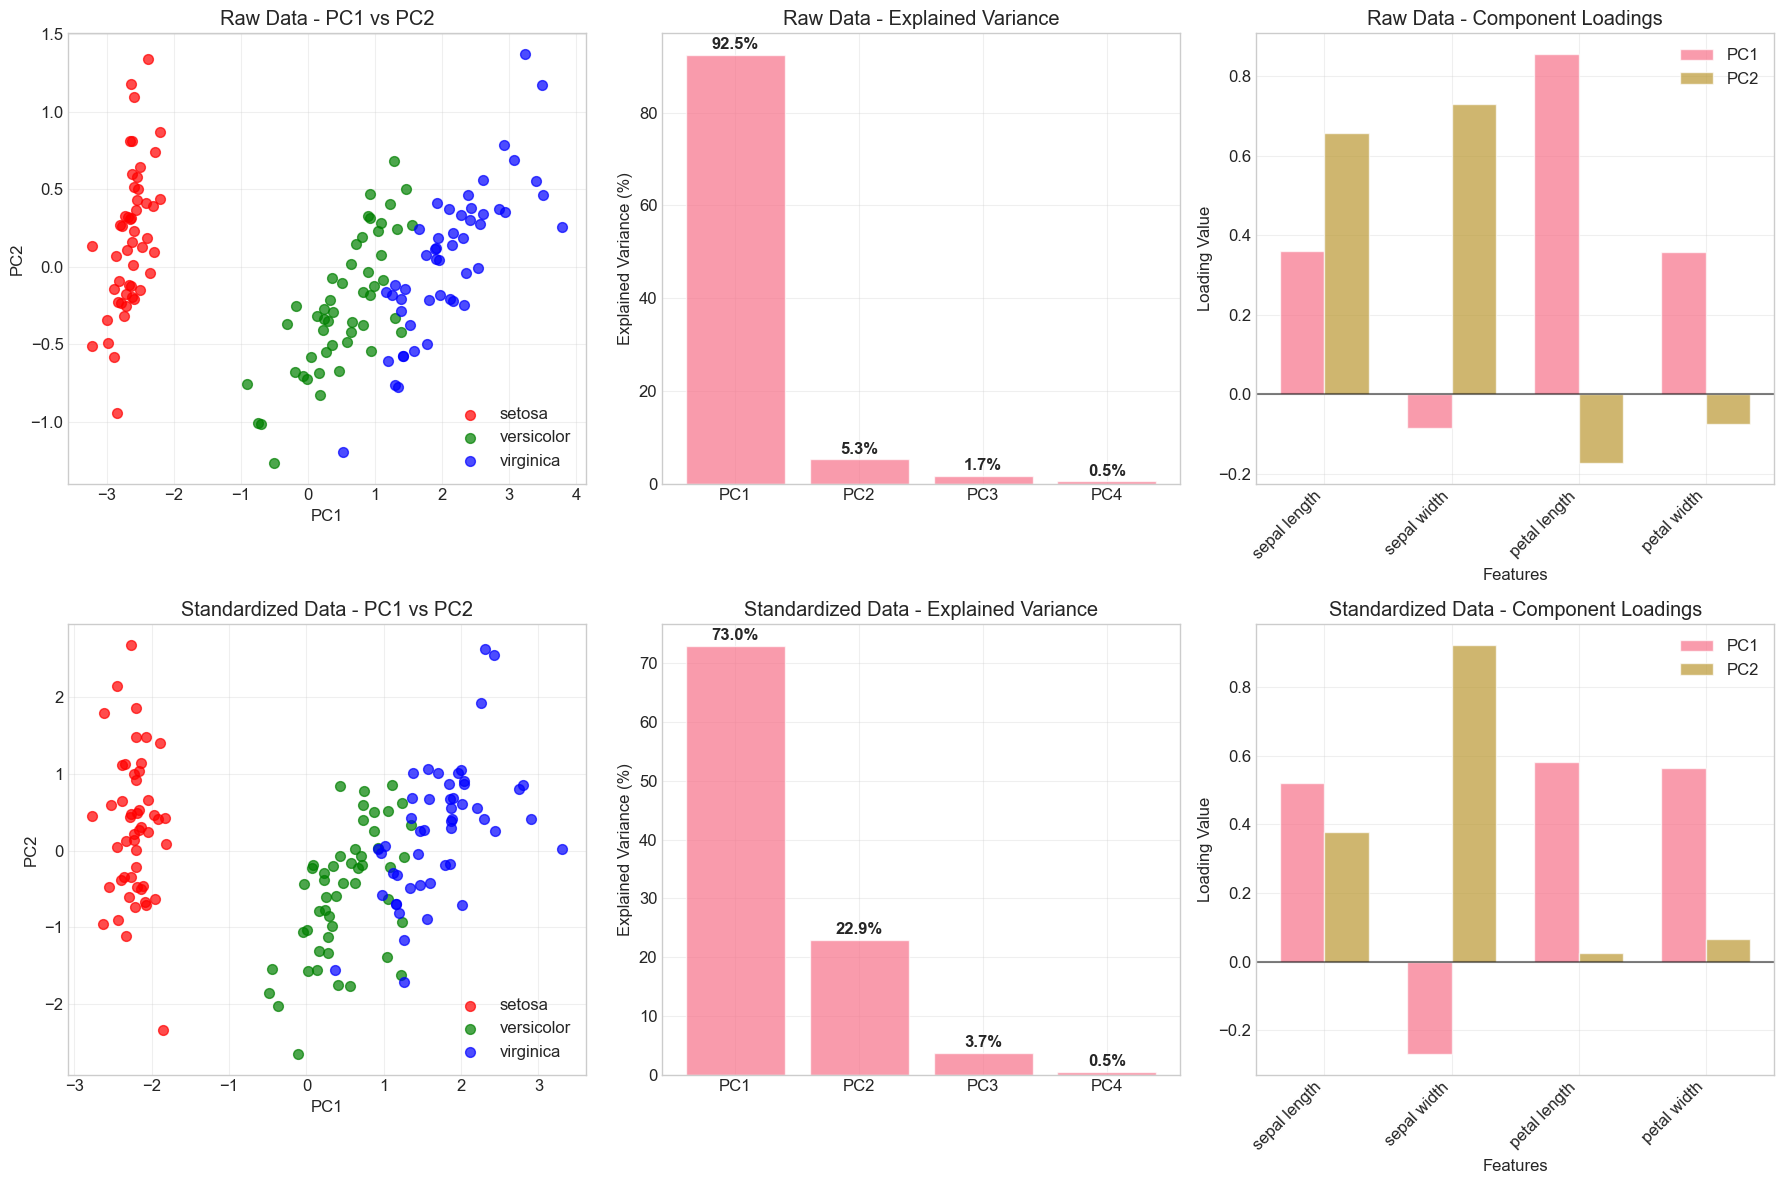


Standardization Impact:
Raw data - PC1 explains: 92.5%
Standardized - PC1 explains: 73.0%

Recommendation: Use standardized data for more balanced component contributions


In [4]:
# Analyze the need for standardization
print("Feature Scale Analysis:")
print("\nFeature Means:")
for i, name in enumerate(feature_names):
    print(f"{name}: {np.mean(X_iris[:, i]):.2f}")

print("\nFeature Standard Deviations:")
for i, name in enumerate(feature_names):
    print(f"{name}: {np.std(X_iris[:, i]):.2f}")

print("\nFeature Ranges:")
for i, name in enumerate(feature_names):
    print(f"{name}: [{np.min(X_iris[:, i]):.1f}, {np.max(X_iris[:, i]):.1f}]")

# Compare PCA results with and without standardization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Without standardization
pca_raw = PCA(n_components=4)
X_pca_raw = pca_raw.fit_transform(X_iris)

# With standardization
scaler = StandardScaler()
X_iris_scaled = scaler.fit_transform(X_iris)
pca_scaled = PCA(n_components=4)
X_pca_scaled = pca_scaled.fit_transform(X_iris_scaled)

# Plot results
scenarios = [('Raw Data', X_pca_raw, pca_raw), ('Standardized Data', X_pca_scaled, pca_scaled)]

for row, (title, X_transformed, pca_obj) in enumerate(scenarios):
    # 2D projection
    colors = ['red', 'green', 'blue']
    for class_idx, (class_name, color) in enumerate(zip(target_names, colors)):
        class_mask = y_iris == class_idx
        axes[row, 0].scatter(X_transformed[class_mask, 0], X_transformed[class_mask, 1],
                           c=color, label=class_name, alpha=0.7, s=50)

    axes[row, 0].set_title(f'{title} - PC1 vs PC2')
    axes[row, 0].set_xlabel('PC1')
    axes[row, 0].set_ylabel('PC2')
    axes[row, 0].legend()
    axes[row, 0].grid(True, alpha=0.3)

    # Explained variance
    components = [f'PC{i+1}' for i in range(4)]
    bars = axes[row, 1].bar(components, pca_obj.explained_variance_ratio_ * 100, alpha=0.7)
    axes[row, 1].set_title(f'{title} - Explained Variance')
    axes[row, 1].set_ylabel('Explained Variance (%)')
    axes[row, 1].grid(True, alpha=0.3)

    # Add percentage labels
    for bar, percentage in zip(bars, pca_obj.explained_variance_ratio_ * 100):
        axes[row, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                         f'{percentage:.1f}%', ha='center', va='bottom', fontweight='bold')

    # Component loadings
    loadings = pca_obj.components_[:2].T  # First two components
    feature_names_short = [name.replace(' (cm)', '') for name in feature_names]

    x = np.arange(len(feature_names_short))
    width = 0.35

    bars1 = axes[row, 2].bar(x - width/2, loadings[:, 0], width,
                            label='PC1', alpha=0.7, color='C0')
    bars2 = axes[row, 2].bar(x + width/2, loadings[:, 1], width,
                            label='PC2', alpha=0.7, color='C1')

    axes[row, 2].set_title(f'{title} - Component Loadings')
    axes[row, 2].set_xlabel('Features')
    axes[row, 2].set_ylabel('Loading Value')
    axes[row, 2].set_xticks(x)
    axes[row, 2].set_xticklabels(feature_names_short, rotation=45, ha='right')
    axes[row, 2].legend()
    axes[row, 2].grid(True, alpha=0.3)
    axes[row, 2].axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.show()

print("\nStandardization Impact:")
print(f"Raw data - PC1 explains: {pca_raw.explained_variance_ratio_[0]*100:.1f}%")
print(f"Standardized - PC1 explains: {pca_scaled.explained_variance_ratio_[0]*100:.1f}%")
print(f"\nRecommendation: Use standardized data for more balanced component contributions")

## Component Interpretation

Interpreting what the principal components represent:

In [12]:
# Use standardized data for detailed analysis
pca_iris = PCA(n_components=4)
X_iris_pca = pca_iris.fit_transform(X_iris_scaled) # Also try with X_iris

print("Detailed Principal Component Analysis:")
print(f"Total components: {pca_iris.n_components_}")
print(f"Explained variance ratios: {pca_iris.explained_variance_ratio_}")
print(f"Cumulative variance: {np.cumsum(pca_iris.explained_variance_ratio_)}")

# Component interpretation
component_interpretations = []
feature_names_short = [name.replace(' (cm)', '').replace('sepal ', 'Sep.').replace('petal ', 'Pet.') for name in feature_names]

print("\nComponent Interpretation:")
for i in range(4):
    loadings = pca_iris.components_[i]

    # Find dominant features
    abs_loadings = np.abs(loadings)
    dominant_indices = np.argsort(abs_loadings)[::-1]

    print(f"\nPC{i+1} ({pca_iris.explained_variance_ratio_[i]*100:.1f}% variance):")

    interpretation = ""
    for j in dominant_indices[:2]:  # Top 2 features
        direction = "positively" if loadings[j] > 0 else "negatively"
        print(f"  • {feature_names[j]} ({direction}, loading: {loadings[j]:.3f})")
        interpretation += f"{feature_names_short[j]}({'+' if loadings[j] > 0 else '-'}) "

    component_interpretations.append(interpretation.strip())

    # Biological interpretation
    if i == 0:
        print(f"  → Interpretation: Overall flower size (all measurements contribute positively)")
    elif i == 1:
        if abs(loadings[0]) > abs(loadings[2]):  # Sepal vs Petal contrast
            print(f"  → Interpretation: Sepal vs Petal size contrast")
        else:
            print(f"  → Interpretation: Length vs Width contrast")
    elif i == 2:
        print(f"  → Interpretation: Subtle shape variations")
    else:
        print(f"  → Interpretation: Residual variation (likely noise)")

Detailed Principal Component Analysis:
Total components: 4
Explained variance ratios: [0.72962445 0.22850762 0.03668922 0.00517871]
Cumulative variance: [0.72962445 0.95813207 0.99482129 1.        ]

Component Interpretation:

PC1 (73.0% variance):
  • petal length (cm) (positively, loading: 0.580)
  • petal width (cm) (positively, loading: 0.565)
  → Interpretation: Overall flower size (all measurements contribute positively)

PC2 (22.9% variance):
  • sepal width (cm) (positively, loading: 0.923)
  • sepal length (cm) (positively, loading: 0.377)
  → Interpretation: Sepal vs Petal size contrast

PC3 (3.7% variance):
  • sepal length (cm) (positively, loading: 0.720)
  • petal width (cm) (negatively, loading: -0.634)
  → Interpretation: Subtle shape variations

PC4 (0.5% variance):
  • petal length (cm) (positively, loading: 0.801)
  • petal width (cm) (negatively, loading: -0.524)
  → Interpretation: Residual variation (likely noise)


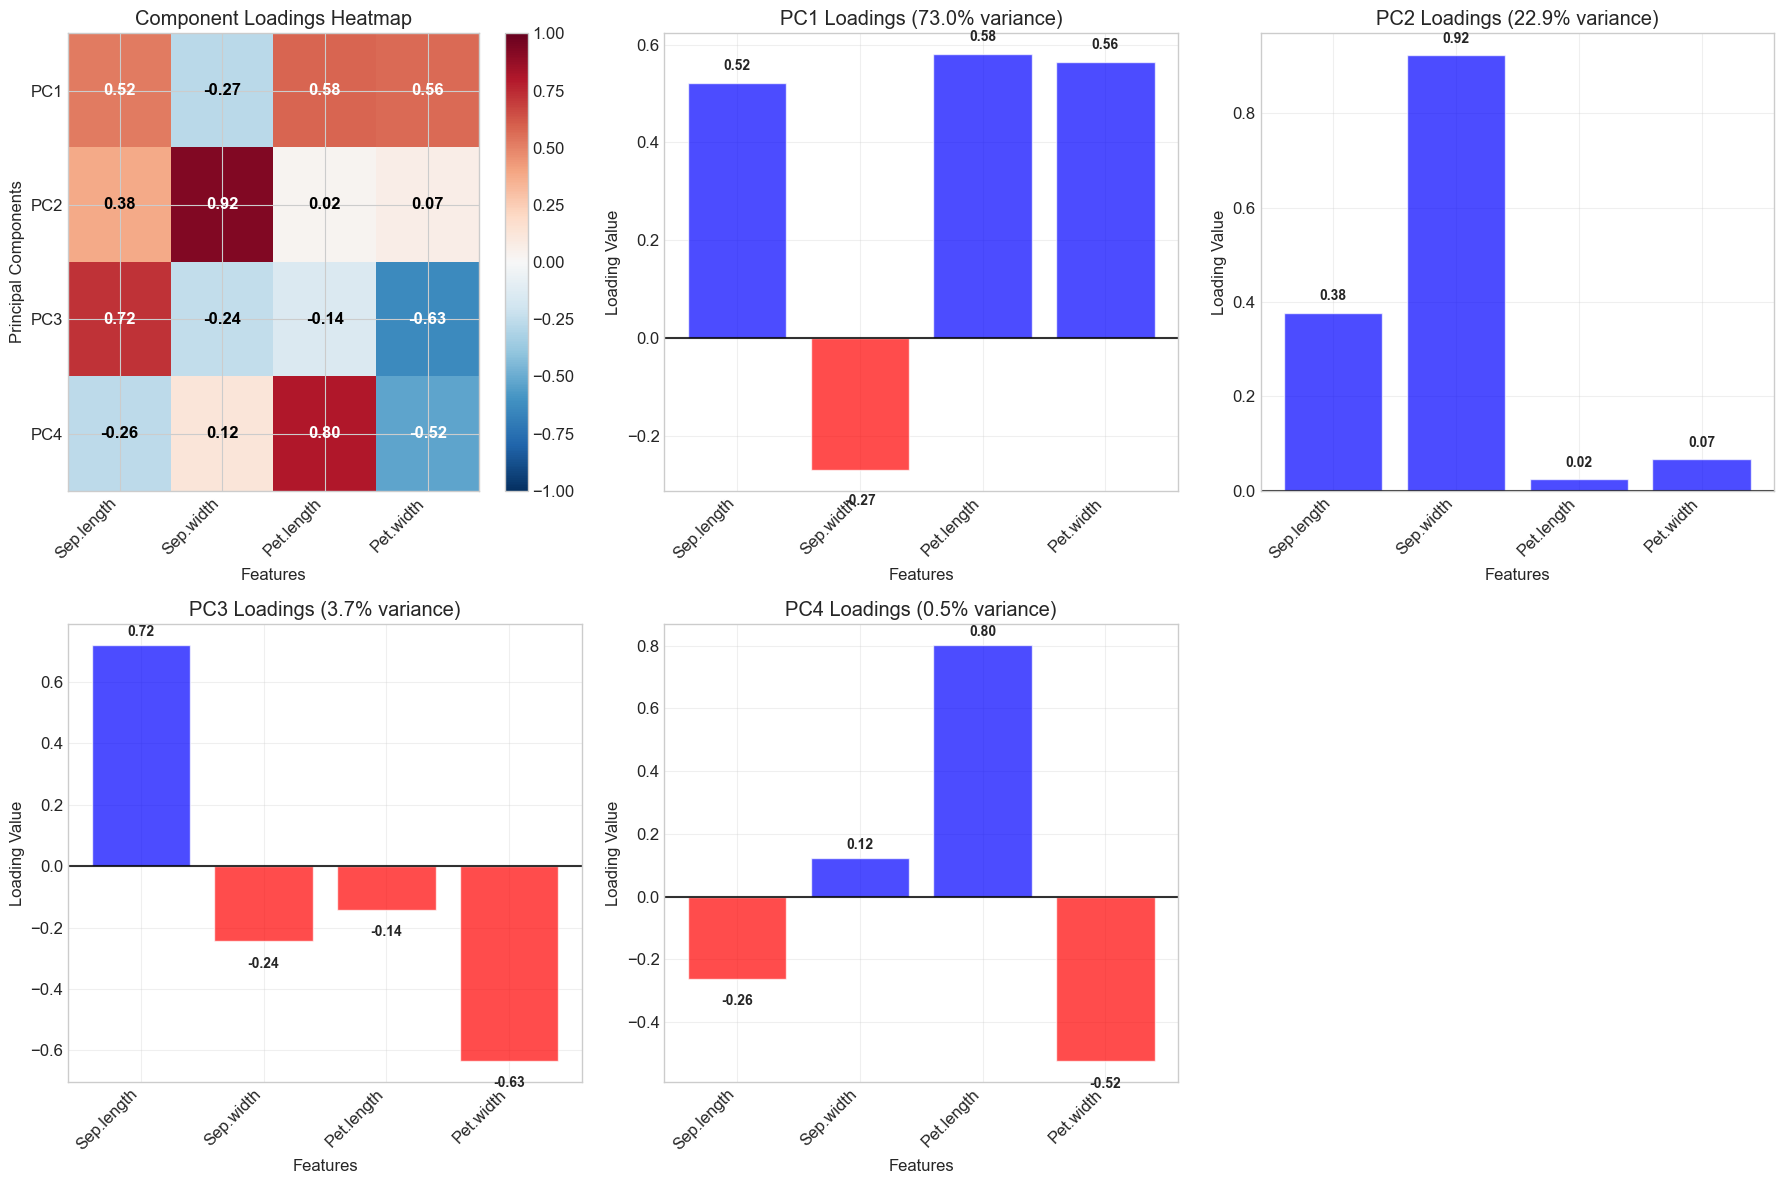

In [13]:
# Create comprehensive visualization of component loadings
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Loadings heatmap
loadings_matrix = pca_iris.components_
im = axes[0, 0].imshow(loadings_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
axes[0, 0].set_title('Component Loadings Heatmap')
axes[0, 0].set_xlabel('Features')
axes[0, 0].set_ylabel('Principal Components')
axes[0, 0].set_xticks(range(len(feature_names_short)))
axes[0, 0].set_yticks(range(4))
axes[0, 0].set_xticklabels(feature_names_short, rotation=45, ha='right')
axes[0, 0].set_yticklabels([f'PC{i+1}' for i in range(4)])

# Add loading values
for i in range(4):
    for j in range(len(feature_names)):
        text = axes[0, 0].text(j, i, f'{loadings_matrix[i, j]:.2f}',
                             ha="center", va="center",
                             color="white" if abs(loadings_matrix[i, j]) > 0.5 else "black",
                             fontweight='bold')

plt.colorbar(im, ax=axes[0, 0])

# Individual component loadings
for i in range(4):
    ax_idx = (i // 2, (i % 2) + 1) if i < 2 else ((i // 2), (i % 2) - 1)
    if i >= 2:
        ax_idx = (1, i - 2)

    ax = axes[ax_idx]

    loadings = pca_iris.components_[i]
    colors = ['red' if load < 0 else 'blue' for load in loadings]

    bars = ax.bar(range(len(feature_names_short)), loadings, color=colors, alpha=0.7)
    ax.set_title(f'PC{i+1} Loadings ({pca_iris.explained_variance_ratio_[i]*100:.1f}% variance)')
    ax.set_xlabel('Features')
    ax.set_ylabel('Loading Value')
    ax.set_xticks(range(len(feature_names_short)))
    ax.set_xticklabels(feature_names_short, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.8)

    # Add value labels
    for bar, value in zip(bars, loadings):
        ax.text(bar.get_x() + bar.get_width()/2,
               value + (0.02 if value >= 0 else -0.05),
               f'{value:.2f}', ha='center',
               va='bottom' if value >= 0 else 'top',
               fontsize=10, fontweight='bold')

# Remove empty subplot
if len(axes.flat) > 5:
    fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

## Scree Plot Analysis

The scree plot helps determine the optimal number of components:

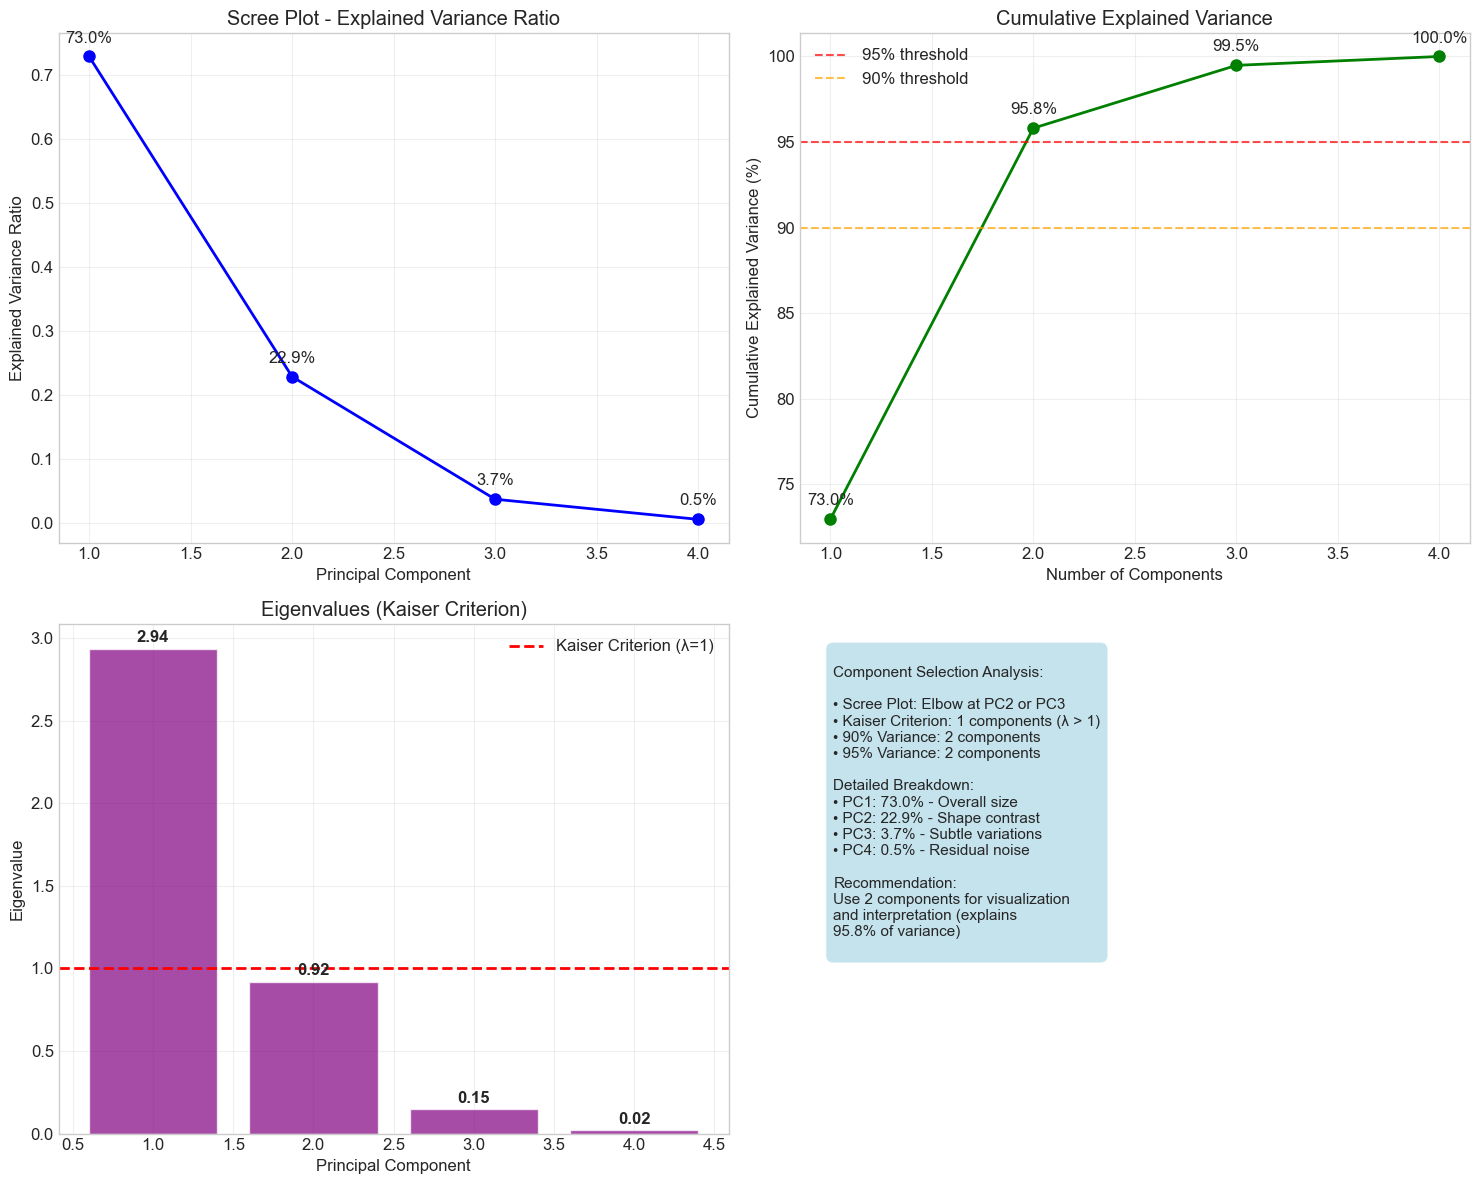

Component Selection Criteria Results:
Kaiser Criterion (eigenvalue > 1): 1 components
90% variance threshold: 2 components
95% variance threshold: 2 components

First 2 components capture 95.8% of total variance
Adding PC3 increases to 99.5% (+3.7%)


In [14]:
# Create comprehensive scree plot analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Traditional scree plot
components = range(1, len(pca_iris.explained_variance_ratio_) + 1)
axes[0, 0].plot(components, pca_iris.explained_variance_ratio_, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_title('Scree Plot - Explained Variance Ratio')
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Explained Variance Ratio')
axes[0, 0].grid(True, alpha=0.3)

# Add percentage labels
for i, (comp, var) in enumerate(zip(components, pca_iris.explained_variance_ratio_)):
    axes[0, 0].annotate(f'{var*100:.1f}%', (comp, var),
                       textcoords="offset points", xytext=(0,10), ha='center')

# Cumulative explained variance
cumulative_var = np.cumsum(pca_iris.explained_variance_ratio_)
axes[0, 1].plot(components, cumulative_var * 100, 'go-', linewidth=2, markersize=8)
axes[0, 1].axhline(y=95, color='red', linestyle='--', alpha=0.7, label='95% threshold')
axes[0, 1].axhline(y=90, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
axes[0, 1].set_title('Cumulative Explained Variance')
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Explained Variance (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Add percentage labels
for i, (comp, cum_var) in enumerate(zip(components, cumulative_var)):
    axes[0, 1].annotate(f'{cum_var*100:.1f}%', (comp, cum_var*100),
                       textcoords="offset points", xytext=(0,10), ha='center')

# Eigenvalue plot (Kaiser criterion)
eigenvalues = pca_iris.explained_variance_
axes[1, 0].bar(components, eigenvalues, alpha=0.7, color='purple')
axes[1, 0].axhline(y=1, color='red', linestyle='--', linewidth=2, label='Kaiser Criterion (λ=1)')
axes[1, 0].set_title('Eigenvalues (Kaiser Criterion)')
axes[1, 0].set_xlabel('Principal Component')
axes[1, 0].set_ylabel('Eigenvalue')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Add eigenvalue labels
for i, (comp, eigval) in enumerate(zip(components, eigenvalues)):
    axes[1, 0].text(comp, eigval + 0.02, f'{eigval:.2f}',
                   ha='center', va='bottom', fontweight='bold')

# Decision summary
axes[1, 1].axis('off')
decision_text = f"""
Component Selection Analysis:

• Scree Plot: Elbow at PC2 or PC3
• Kaiser Criterion: {np.sum(eigenvalues > 1)} components (λ > 1)
• 90% Variance: {np.argmax(cumulative_var >= 0.90) + 1} components
• 95% Variance: {np.argmax(cumulative_var >= 0.95) + 1} components

Detailed Breakdown:
• PC1: {pca_iris.explained_variance_ratio_[0]*100:.1f}% - Overall size
• PC2: {pca_iris.explained_variance_ratio_[1]*100:.1f}% - Shape contrast
• PC3: {pca_iris.explained_variance_ratio_[2]*100:.1f}% - Subtle variations
• PC4: {pca_iris.explained_variance_ratio_[3]*100:.1f}% - Residual noise

Recommendation:
Use 2 components for visualization
and interpretation (explains
{(pca_iris.explained_variance_ratio_[0] + pca_iris.explained_variance_ratio_[1])*100:.1f}% of variance)
"""

axes[1, 1].text(0.05, 0.95, decision_text, transform=axes[1, 1].transAxes,
               fontsize=11, verticalalignment='top',
               bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.7))

plt.tight_layout()
plt.show()

# Print decision criteria results
print("Component Selection Criteria Results:")
print(f"Kaiser Criterion (eigenvalue > 1): {np.sum(eigenvalues > 1)} components")
print(f"90% variance threshold: {np.argmax(cumulative_var >= 0.90) + 1} components")
print(f"95% variance threshold: {np.argmax(cumulative_var >= 0.95) + 1} components")
print(f"\nFirst 2 components capture {cumulative_var[1]*100:.1f}% of total variance")
print(f"Adding PC3 increases to {cumulative_var[2]*100:.1f}% (+{(cumulative_var[2]-cumulative_var[1])*100:.1f}%)")

### Optimal 2D Visualization

Based on the results of analysis, create the 2D PCA visualization:

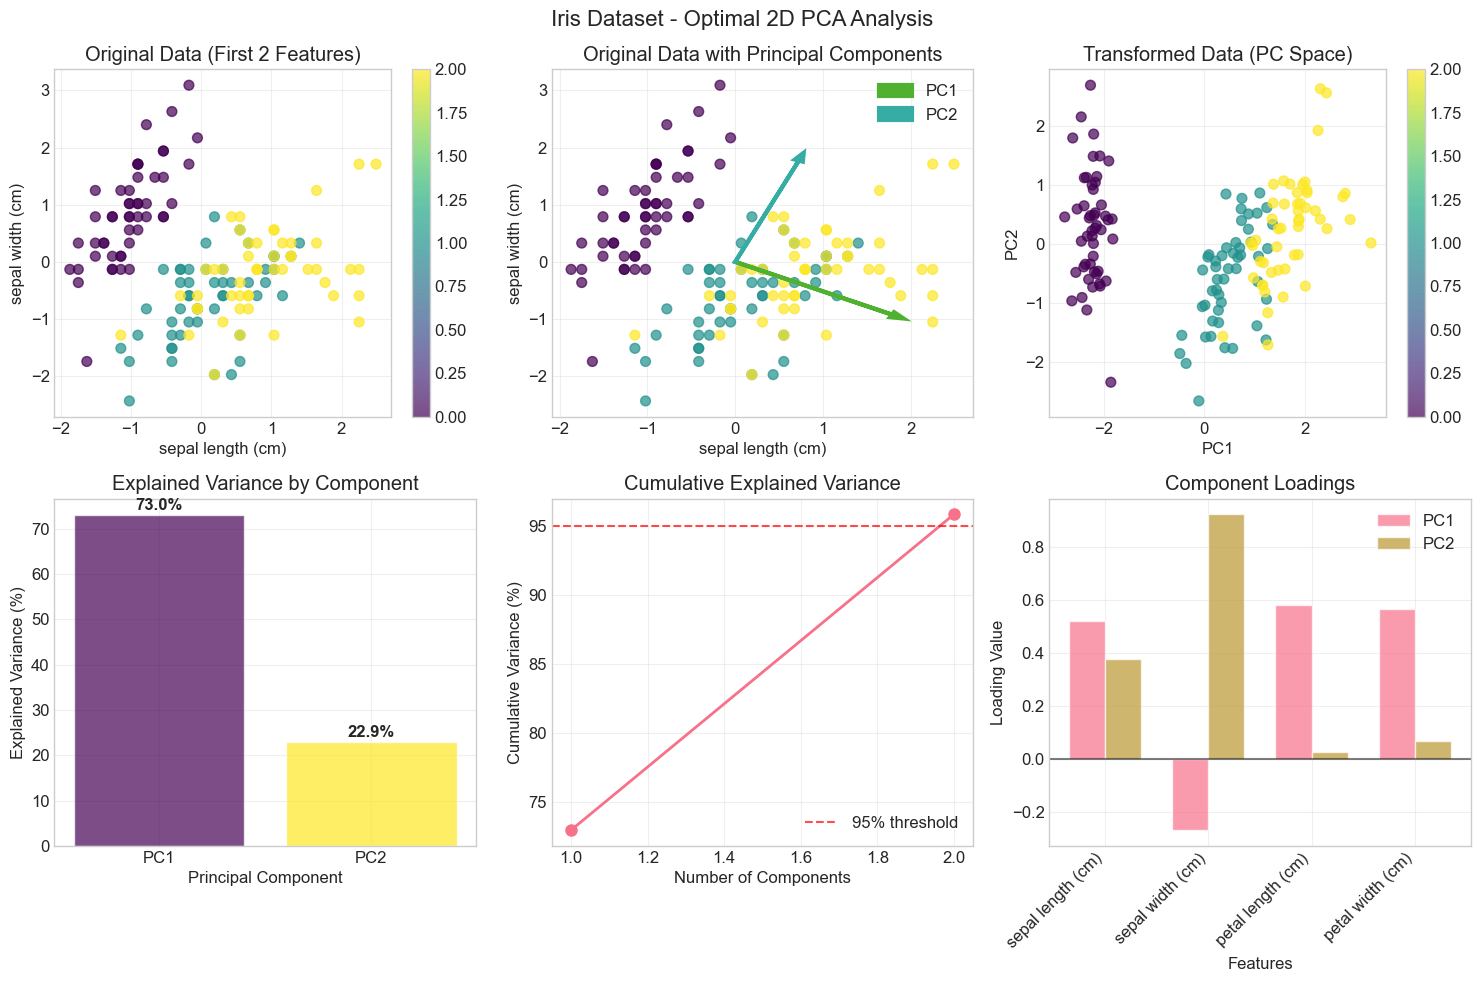

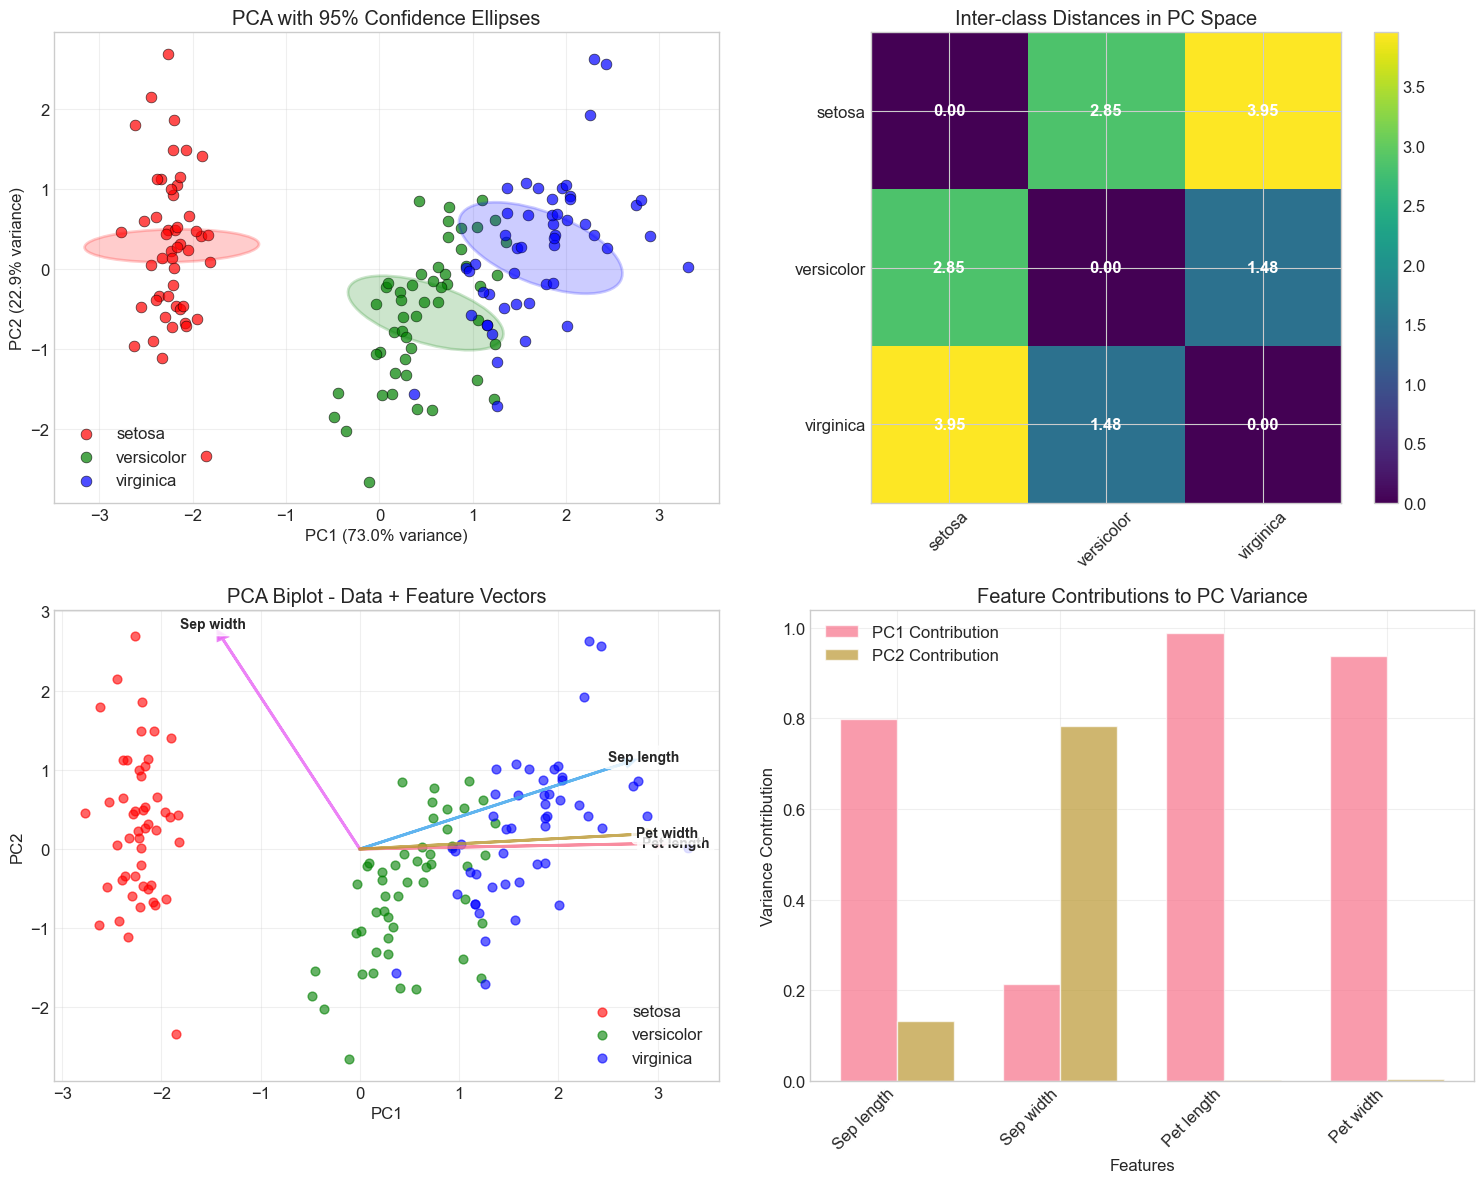


Class Separation Analysis in PC Space:
Setosa vs Versicolor distance: 2.85
Setosa vs Virginica distance: 3.95
Versicolor vs Virginica distance: 1.48

Best separated: Setosa (clearly distinct from others)
Most similar: Versicolor and Virginica


In [15]:
# Create the optimal 2D PCA visualization
pca_2d = PCA(n_components=2)
X_iris_2d = pca_2d.fit_transform(X_iris_scaled)

# Use our visualization utility with enhancements
plot_2d_pca_results(X_iris_scaled, X_iris_2d, pca_2d, labels=y_iris,
                   title="Iris Dataset - Optimal 2D PCA Analysis",
                   feature_names=feature_names)

# Additional detailed 2D analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Enhanced scatter plot with confidence ellipses
colors = ['red', 'green', 'blue']
for class_idx, (class_name, color) in enumerate(zip(target_names, colors)):
    class_mask = y_iris == class_idx
    class_data = X_iris_2d[class_mask]

    # Plot points
    axes[0, 0].scatter(class_data[:, 0], class_data[:, 1],
                      c=color, label=class_name, alpha=0.7, s=60, edgecolors='black', linewidth=0.5)

    # Add confidence ellipse
    from matplotlib.patches import Ellipse
    mean = np.mean(class_data, axis=0)
    cov = np.cov(class_data.T)
    eigenvals, eigenvecs = np.linalg.eigh(cov)

    # Calculate ellipse parameters
    angle = np.degrees(np.arctan2(eigenvecs[1, 1], eigenvecs[0, 1]))
    width, height = 2 * np.sqrt(eigenvals)

    ellipse = Ellipse(mean, width, height, angle=angle,
                     facecolor=color, alpha=0.2, edgecolor=color, linewidth=2)
    axes[0, 0].add_patch(ellipse)

axes[0, 0].set_title('PCA with 95% Confidence Ellipses')
axes[0, 0].set_xlabel('PC1 (73.0% variance)')
axes[0, 0].set_ylabel('PC2 (22.9% variance)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Class separation analysis
class_centers = []
for class_idx in range(3):
    class_mask = y_iris == class_idx
    center = np.mean(X_iris_2d[class_mask], axis=0)
    class_centers.append(center)

class_centers = np.array(class_centers)

# Calculate pairwise distances between class centers
from scipy.spatial.distance import pdist, squareform
distances = squareform(pdist(class_centers))

# Visualize class separation
im = axes[0, 1].imshow(distances, cmap='viridis')
axes[0, 1].set_title('Inter-class Distances in PC Space')
axes[0, 1].set_xticks(range(3))
axes[0, 1].set_yticks(range(3))
axes[0, 1].set_xticklabels(target_names, rotation=45)
axes[0, 1].set_yticklabels(target_names)

# Add distance values
for i in range(3):
    for j in range(3):
        text = axes[0, 1].text(j, i, f'{distances[i, j]:.2f}',
                             ha="center", va="center", color="white", fontweight='bold')

plt.colorbar(im, ax=axes[0, 1])

# Feature contribution biplot
# Plot data points
for class_idx, (class_name, color) in enumerate(zip(target_names, colors)):
    class_mask = y_iris == class_idx
    axes[1, 0].scatter(X_iris_2d[class_mask, 0], X_iris_2d[class_mask, 1],
                      c=color, label=class_name, alpha=0.6, s=40)

# Add feature vectors (loadings scaled by eigenvalues)
feature_vectors = pca_2d.components_.T * np.sqrt(pca_2d.explained_variance_)
feature_names_short = [name.replace(' (cm)', '').replace('sepal', 'Sep').replace('petal', 'Pet') for name in feature_names]

for i, (feature_name, vector) in enumerate(zip(feature_names_short, feature_vectors)):
    axes[1, 0].arrow(0, 0, vector[0]*3, vector[1]*3,
                    head_width=0.1, head_length=0.1,
                    fc=f'C{i+4}', ec=f'C{i+4}', linewidth=2, alpha=0.8)
    axes[1, 0].text(vector[0]*3.2, vector[1]*3.2, feature_name,
                   fontsize=10, fontweight='bold',
                   ha='center', va='center',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

axes[1, 0].set_title('PCA Biplot - Data + Feature Vectors')
axes[1, 0].set_xlabel('PC1')
axes[1, 0].set_ylabel('PC2')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Variance explained by original features in PC space
feature_variance_pc1 = (pca_2d.components_[0] ** 2) * pca_2d.explained_variance_[0]
feature_variance_pc2 = (pca_2d.components_[1] ** 2) * pca_2d.explained_variance_[1]

x = np.arange(len(feature_names_short))
width = 0.35

bars1 = axes[1, 1].bar(x - width/2, feature_variance_pc1, width,
                      label='PC1 Contribution', alpha=0.7, color='C0')
bars2 = axes[1, 1].bar(x + width/2, feature_variance_pc2, width,
                      label='PC2 Contribution', alpha=0.7, color='C1')

axes[1, 1].set_title('Feature Contributions to PC Variance')
axes[1, 1].set_xlabel('Features')
axes[1, 1].set_ylabel('Variance Contribution')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(feature_names_short, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nClass Separation Analysis in PC Space:")
print(f"Setosa vs Versicolor distance: {distances[0, 1]:.2f}")
print(f"Setosa vs Virginica distance: {distances[0, 2]:.2f}")
print(f"Versicolor vs Virginica distance: {distances[1, 2]:.2f}")
print(f"\nBest separated: Setosa (clearly distinct from others)")
print(f"Most similar: Versicolor and Virginica")

## Component Loadings Deep Dive

Analysis of each principal component and the meaning in biological terms:

In [16]:
# Detailed component interpretation
print("=" * 60)
print("DETAILED PRINCIPAL COMPONENT INTERPRETATION")
print("=" * 60)

# Component loadings table
loadings_df = pd.DataFrame(
    pca_2d.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_names
)

print("\nComponent Loadings:")
print(loadings_df.round(3))

# Calculate feature importance (squared loadings)
feature_importance_pc1 = pca_2d.components_[0] ** 2
feature_importance_pc2 = pca_2d.components_[1] ** 2

importance_df = pd.DataFrame({
    'PC1_Importance': feature_importance_pc1,
    'PC2_Importance': feature_importance_pc2,
    'Total_Importance': feature_importance_pc1 + feature_importance_pc2
}, index=feature_names)

print("\nFeature Importance (Squared Loadings):")
print(importance_df.round(3))

# Biological interpretation
print("\n" + "=" * 60)
print("BIOLOGICAL INTERPRETATION")
print("=" * 60)

pc1_loadings = pca_2d.components_[0]
pc2_loadings = pca_2d.components_[1]

print(f"\nPC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance):")
print(f"  Loadings: {dict(zip(feature_names_short, pc1_loadings.round(3)))}")
if np.all(pc1_loadings > 0):
    print(f"  → OVERALL FLOWER SIZE: All measurements contribute positively")
    print(f"  → Larger flowers have higher PC1 scores")
    print(f"  → This represents the primary axis of morphological variation")
else:
    print(f"  → CONTRAST between different flower parts")

print(f"\nPC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance):")
print(f"  Loadings: {dict(zip(feature_names_short, pc2_loadings.round(3)))}")

# Analyze PC2 pattern
sepal_avg = np.mean([pc2_loadings[0], pc2_loadings[1]])  # sepal length, width
petal_avg = np.mean([pc2_loadings[2], pc2_loadings[3]])  # petal length, width

if sepal_avg * petal_avg < 0:  # Opposite signs
    print(f"  → SEPAL vs PETAL CONTRAST: Sepals and petals vary inversely")
    if sepal_avg > 0:
        print(f"  → High PC2: Large sepals, small petals")
        print(f"  → Low PC2: Small sepals, large petals")
    else:
        print(f"  → High PC2: Small sepals, large petals")
        print(f"  → Low PC2: Large sepals, small petals")
else:
    length_avg = np.mean([pc2_loadings[0], pc2_loadings[2]])  # lengths
    width_avg = np.mean([pc2_loadings[1], pc2_loadings[3]])   # widths

    if length_avg * width_avg < 0:
        print(f"  → LENGTH vs WIDTH CONTRAST: Shape variation")
        if length_avg > 0:
            print(f"  → High PC2: Long, narrow flowers")
            print(f"  → Low PC2: Short, wide flowers")
        else:
            print(f"  → High PC2: Short, wide flowers")
            print(f"  → Low PC2: Long, narrow flowers")

# Species characterization in PC space
print(f"\n" + "=" * 60)
print("SPECIES CHARACTERIZATION IN PC SPACE")
print("=" * 60)

for class_idx, class_name in enumerate(target_names):
    class_mask = y_iris == class_idx
    class_pc1_mean = np.mean(X_iris_2d[class_mask, 0])
    class_pc2_mean = np.mean(X_iris_2d[class_mask, 1])

    print(f"\n{class_name.upper()}:")
    print(f"  PC1 mean: {class_pc1_mean:.2f} (size: {'large' if class_pc1_mean > 0 else 'small'})")
    print(f"  PC2 mean: {class_pc2_mean:.2f}")

    # Characterize based on PC2
    if class_pc2_mean > 0.5:
        pc2_char = "high PC2 - distinctive shape pattern"
    elif class_pc2_mean < -0.5:
        pc2_char = "low PC2 - opposite shape pattern"
    else:
        pc2_char = "moderate PC2 - intermediate shape"

    print(f"  Shape: {pc2_char}")

    # Original feature means for context
    class_features = X_iris[class_mask]
    feature_means = np.mean(class_features, axis=0)
    print(f"  Original features: {dict(zip(feature_names_short, feature_means.round(2)))}")

DETAILED PRINCIPAL COMPONENT INTERPRETATION

Component Loadings:
                     PC1    PC2
sepal length (cm)  0.521  0.377
sepal width (cm)  -0.269  0.923
petal length (cm)  0.580  0.024
petal width (cm)   0.565  0.067

Feature Importance (Squared Loadings):
                   PC1_Importance  PC2_Importance  Total_Importance
sepal length (cm)           0.272           0.142             0.414
sepal width (cm)            0.073           0.852             0.925
petal length (cm)           0.337           0.001             0.337
petal width (cm)            0.319           0.004             0.324

BIOLOGICAL INTERPRETATION

PC1 (73.0% variance):
  Loadings: {'Sep length': np.float64(0.521), 'Sep width': np.float64(-0.269), 'Pet length': np.float64(0.58), 'Pet width': np.float64(0.565)}
  → CONTRAST between different flower parts

PC2 (22.9% variance):
  Loadings: {'Sep length': np.float64(0.377), 'Sep width': np.float64(0.923), 'Pet length': np.float64(0.024), 'Pet width': np.float64(

In [17]:
# Save results for later use
iris_results = {
    'pca_model': pca_2d,
    'transformed_data': X_iris_2d,
    'original_data': X_iris_scaled,
    'labels': y_iris,
    'explained_variance_ratio': pca_2d.explained_variance_ratio_,
    'feature_names': feature_names,
    'target_names': target_names
}

# Save to processed data directory
import pickle
with open('../data/processed/iris_pca_results.pkl', 'wb') as f:
    pickle.dump(iris_results, f)

print("✅ Iris PCA analysis complete!")
print(f"📊 Results saved to ../data/processed/iris_pca_results.pkl")
print(f"🎯 Key finding: First 2 PCs explain {(pca_2d.explained_variance_ratio_[0] + pca_2d.explained_variance_ratio_[1])*100:.1f}% of variance")
print(f"🔍 PC1 represents overall flower size, PC2 represents shape contrasts")
print(f"🌸 Setosa is clearly separated, while Versicolor and Virginica show some overlap")

✅ Iris PCA analysis complete!
📊 Results saved to ../data/processed/iris_pca_results.pkl
🎯 Key finding: First 2 PCs explain 95.8% of variance
🔍 PC1 represents overall flower size, PC2 represents shape contrasts
🌸 Setosa is clearly separated, while Versicolor and Virginica show some overlap


## High-Dimensional Dataset Analysis

### MNIST Handwritten Digits Dataset

HIGH-DIMENSIONAL DATASET ANALYSIS

MNIST Digits Dataset:
Data shape: (1797, 64)
Image dimensions: 8x8 = 64 pixels
Number of classes: 10
Classes: [0 1 2 3 4 5 6 7 8 9]
Samples per class: [178 182 177 183 181 182 181 179 174 180]


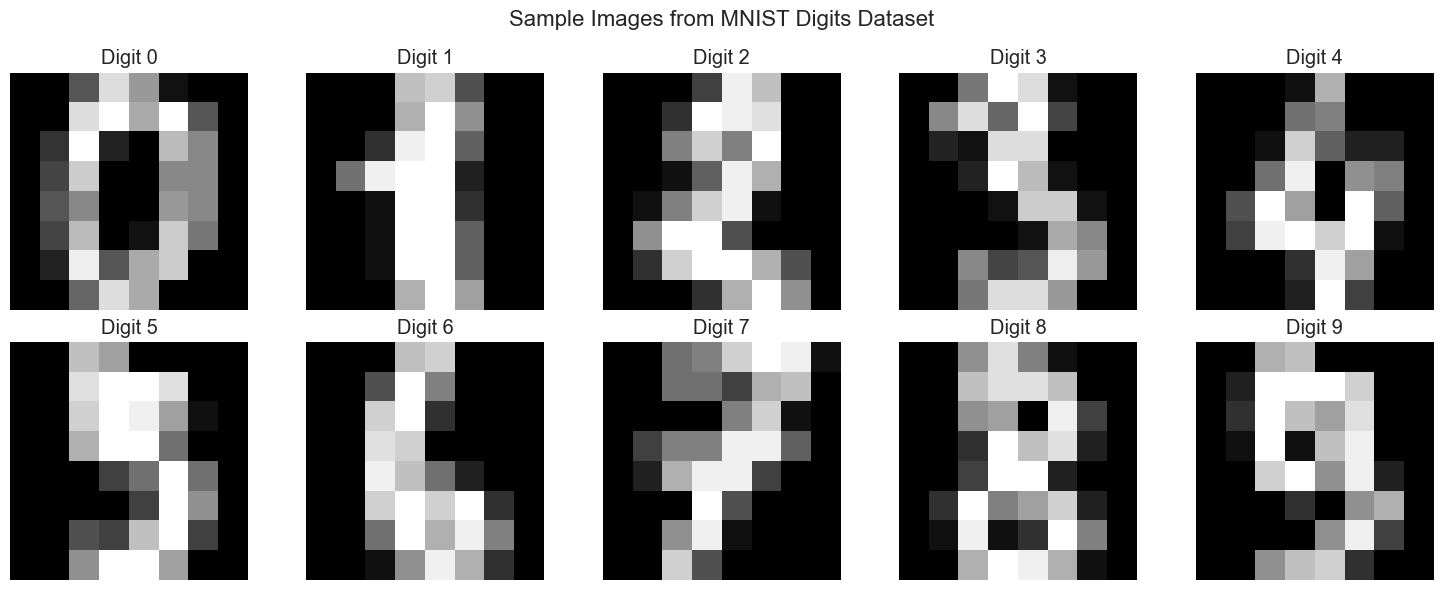


Pixel value statistics:
Min: 0.0
Max: 16.0
Mean: 4.9
Std: 6.0


In [18]:
print("="*60)
print("HIGH-DIMENSIONAL DATASET ANALYSIS")
print("="*60)

# Load MNIST digits dataset (8x8 version for faster computation)
from sklearn.datasets import load_digits

digits = load_digits()
X_digits = digits.data
y_digits = digits.target

print(f"\nMNIST Digits Dataset:")
print(f"Data shape: {X_digits.shape}")
print(f"Image dimensions: 8x8 = {8*8} pixels")
print(f"Number of classes: {len(np.unique(y_digits))}")
print(f"Classes: {np.unique(y_digits)}")
print(f"Samples per class: {np.bincount(y_digits)}")

# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    row, col = i // 5, i % 5
    # Find the first occurrence of each digit
    digit_idx = np.where(y_digits == i)[0][0]
    image = X_digits[digit_idx].reshape(8, 8)

    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].set_title(f'Digit {i}')
    axes[row, col].axis('off')

plt.suptitle('Sample Images from MNIST Digits Dataset', fontsize=16)
plt.tight_layout()
plt.show()

# Basic statistics
print(f"\nPixel value statistics:")
print(f"Min: {X_digits.min():.1f}")
print(f"Max: {X_digits.max():.1f}")
print(f"Mean: {X_digits.mean():.1f}")
print(f"Std: {X_digits.std():.1f}")

### PCA Analysis on MNIST Digits


PCA ANALYSIS ON MNIST DIGITS
Analyzing component requirements...
80% variance explained by 13 components
85% variance explained by 17 components
90% variance explained by 21 components
95% variance explained by 29 components
99% variance explained by 41 components


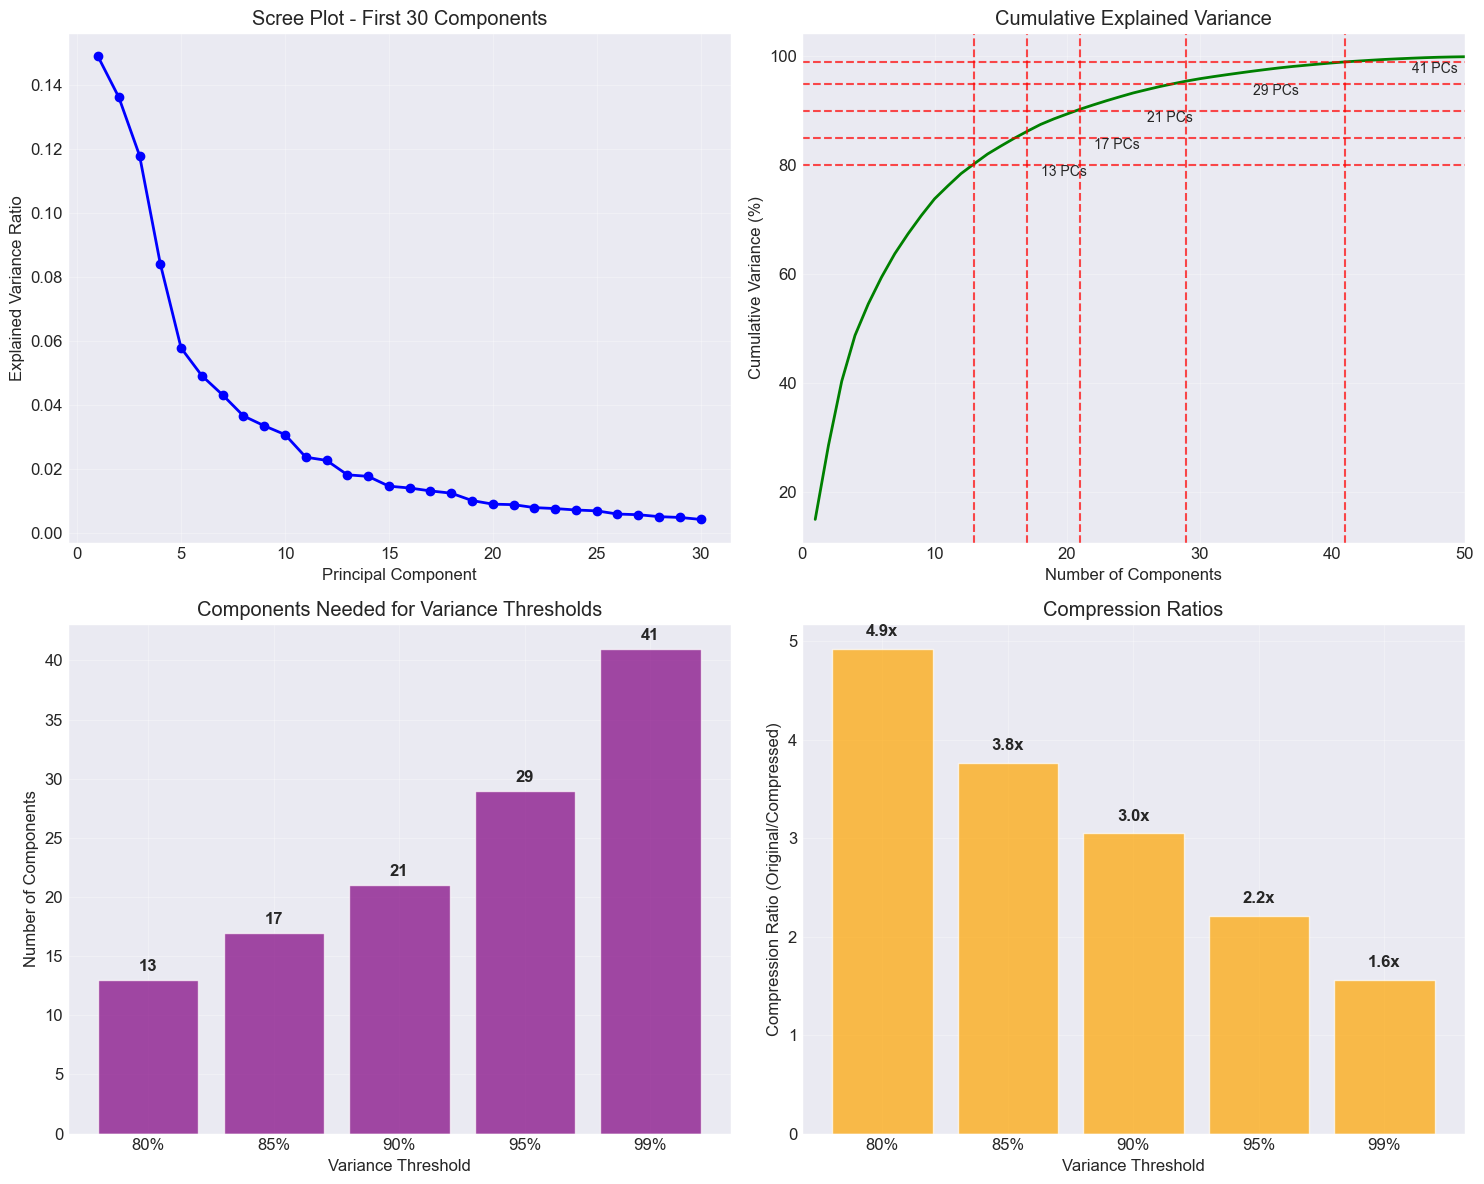


Compression Analysis:
Original dimensionality: 64 features
80% variance: 13 components → 4.9x compression
85% variance: 17 components → 3.8x compression
90% variance: 21 components → 3.0x compression
95% variance: 29 components → 2.2x compression
99% variance: 41 components → 1.6x compression


In [19]:
print("\n" + "="*50)
print("PCA ANALYSIS ON MNIST DIGITS")
print("="*50)

# Apply PCA to find optimal number of components
print("Analyzing component requirements...")

# First, let's see how many components we need for different variance thresholds
pca_full = PCA()
pca_full.fit(X_digits)

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find components needed for different thresholds
variance_thresholds = [0.80, 0.85, 0.90, 0.95, 0.99]
components_needed = []

for threshold in variance_thresholds:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    components_needed.append(n_components)
    print(f"{threshold*100:.0f}% variance explained by {n_components:2d} components")

# Visualization of component analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Scree plot (first 30 components)
components_range = range(1, min(31, len(pca_full.explained_variance_ratio_) + 1))
axes[0, 0].plot(components_range, pca_full.explained_variance_ratio_[:30], 'bo-', linewidth=2, markersize=6)
axes[0, 0].set_title('Scree Plot - First 30 Components')
axes[0, 0].set_xlabel('Principal Component')
axes[0, 0].set_ylabel('Explained Variance Ratio')
axes[0, 0].grid(True, alpha=0.3)

# Cumulative variance
axes[0, 1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, 'g-', linewidth=2)
for threshold, n_comp in zip(variance_thresholds, components_needed):
    axes[0, 1].axhline(y=threshold*100, color='red', linestyle='--', alpha=0.7)
    axes[0, 1].axvline(x=n_comp, color='red', linestyle='--', alpha=0.7)
    axes[0, 1].annotate(f'{n_comp} PCs', xy=(n_comp, threshold*100),
                       xytext=(n_comp+5, threshold*100-2), fontsize=10)

axes[0, 1].set_title('Cumulative Explained Variance')
axes[0, 1].set_xlabel('Number of Components')
axes[0, 1].set_ylabel('Cumulative Variance (%)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(0, 50)

# Component requirements bar chart
axes[1, 0].bar([f'{t*100:.0f}%' for t in variance_thresholds], components_needed,
              alpha=0.7, color='purple')
axes[1, 0].set_title('Components Needed for Variance Thresholds')
axes[1, 0].set_xlabel('Variance Threshold')
axes[1, 0].set_ylabel('Number of Components')
axes[1, 0].grid(True, alpha=0.3)

# Add value labels on bars
for i, (threshold, n_comp) in enumerate(zip(variance_thresholds, components_needed)):
    axes[1, 0].text(i, n_comp + 0.5, str(n_comp), ha='center', va='bottom', fontweight='bold')

# Compression ratio analysis
original_size = X_digits.shape[1]  # 64 pixels
compression_ratios = [original_size / n_comp for n_comp in components_needed]

axes[1, 1].bar([f'{t*100:.0f}%' for t in variance_thresholds], compression_ratios,
              alpha=0.7, color='orange')
axes[1, 1].set_title('Compression Ratios')
axes[1, 1].set_xlabel('Variance Threshold')
axes[1, 1].set_ylabel('Compression Ratio (Original/Compressed)')
axes[1, 1].grid(True, alpha=0.3)

# Add value labels
for i, ratio in enumerate(compression_ratios):
    axes[1, 1].text(i, ratio + 0.1, f'{ratio:.1f}x', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nCompression Analysis:")
print(f"Original dimensionality: {original_size} features")
for threshold, n_comp, ratio in zip(variance_thresholds, components_needed, compression_ratios):
    print(f"{threshold*100:.0f}% variance: {n_comp:2d} components → {ratio:.1f}x compression")

### Detailed Analysis with Optimal Components


Detailed analysis with 20 components:
Captures 89.4% of variance
Original shape: (1797, 64)
Transformed shape: (1797, 20)
Dimensionality reduction: 64 → 20
Data compression ratio: 3.2x


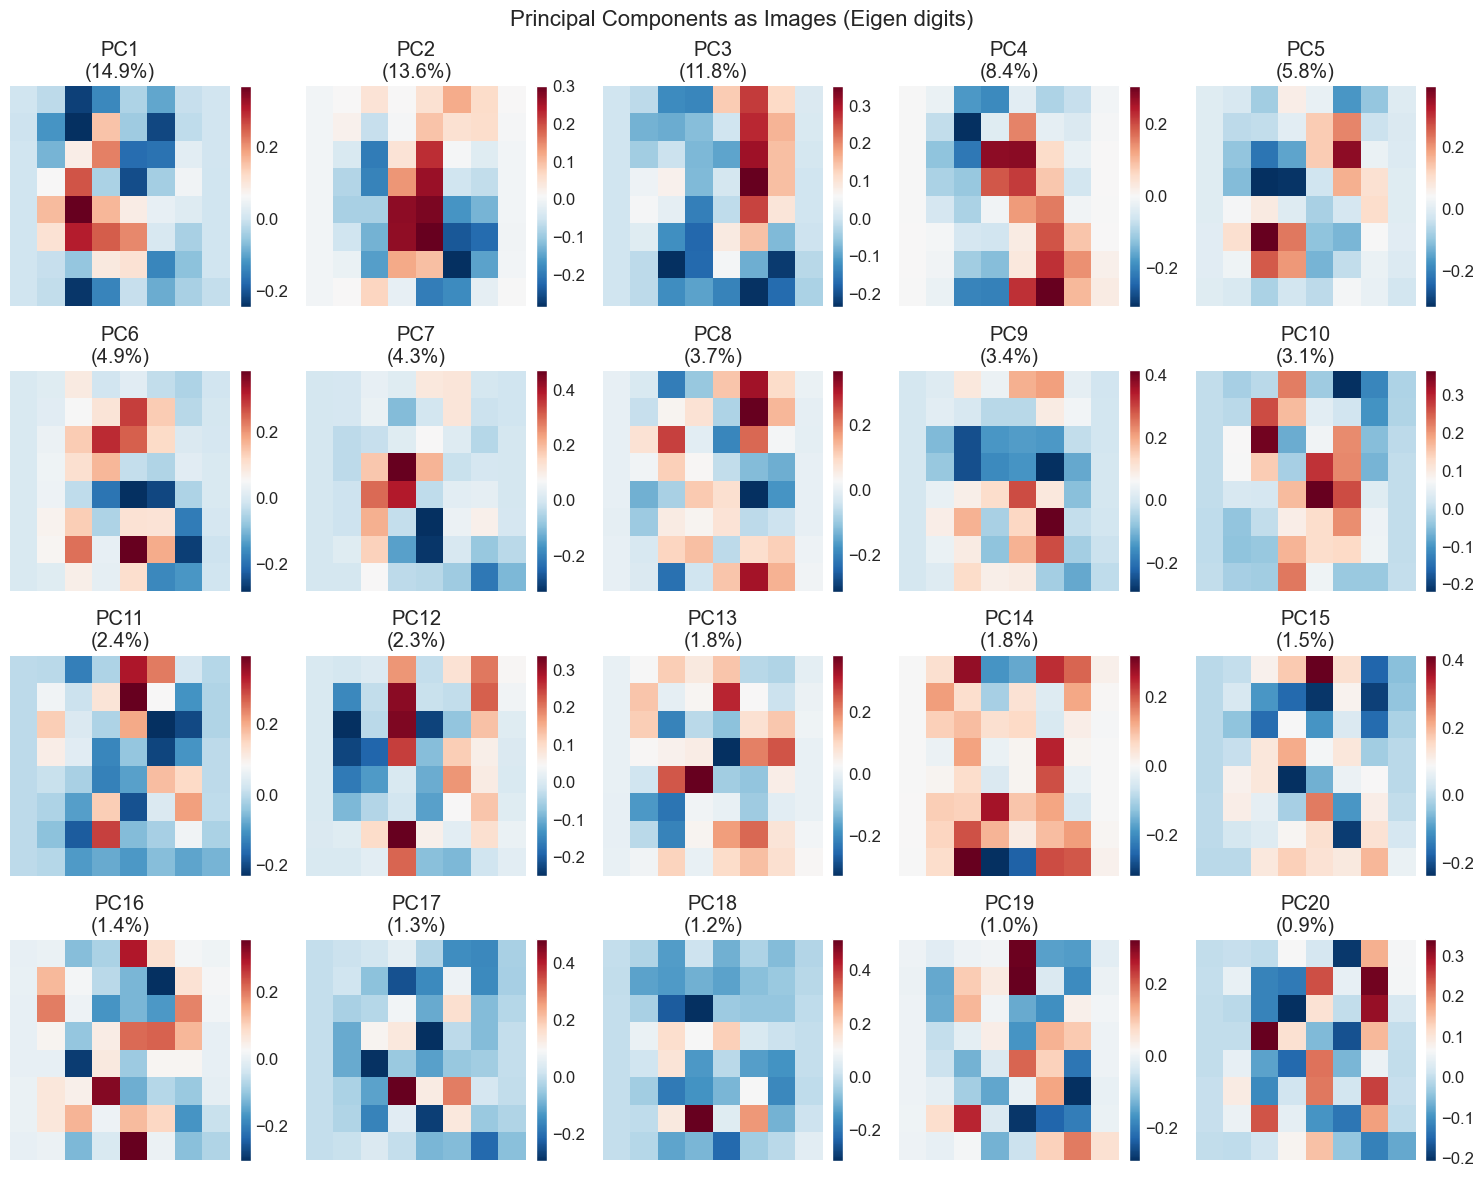

Principal Components Interpretation:
• PC1-PC3: Capture overall brightness and basic shape variations
• PC4-PC10: Capture stroke thickness and orientation patterns
• PC11-PC20: Capture fine details and digit-specific features


In [20]:
# Choose 20 components for detailed analysis (good balance of variance vs. complexity)
n_components_analysis = 20

print(f"\nDetailed analysis with {n_components_analysis} components:")
print(f"Captures {cumulative_variance[n_components_analysis-1]*100:.1f}% of variance")

pca_digits = PCA(n_components=n_components_analysis)
X_digits_pca = pca_digits.fit_transform(X_digits)

print(f"Original shape: {X_digits.shape}")
print(f"Transformed shape: {X_digits_pca.shape}")
print(f"Dimensionality reduction: {X_digits.shape[1]} → {X_digits_pca.shape[1]}")
print(f"Data compression ratio: {X_digits.shape[1]/X_digits_pca.shape[1]:.1f}x")

# Visualize the principal components as images
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

for i in range(min(20, n_components_analysis)):
    # Reshape component to 8x8 image
    component_image = pca_digits.components_[i].reshape(8, 8)

    im = axes[i].imshow(component_image, cmap='RdBu_r', aspect='equal')
    axes[i].set_title(f'PC{i+1}\n({pca_digits.explained_variance_ratio_[i]*100:.1f}%)')
    axes[i].axis('off')

    # Add colorbar to show the scale
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.suptitle('Principal Components as Images (Eigen digits)', fontsize=16)
plt.tight_layout()
plt.show()

print("Principal Components Interpretation:")
print("• PC1-PC3: Capture overall brightness and basic shape variations")
print("• PC4-PC10: Capture stroke thickness and orientation patterns")
print("• PC11-PC20: Capture fine details and digit-specific features")

### Data Reconstruction Analysis


DATA RECONSTRUCTION ANALYSIS
Analyzing reconstruction of digit 4 (sample 100)


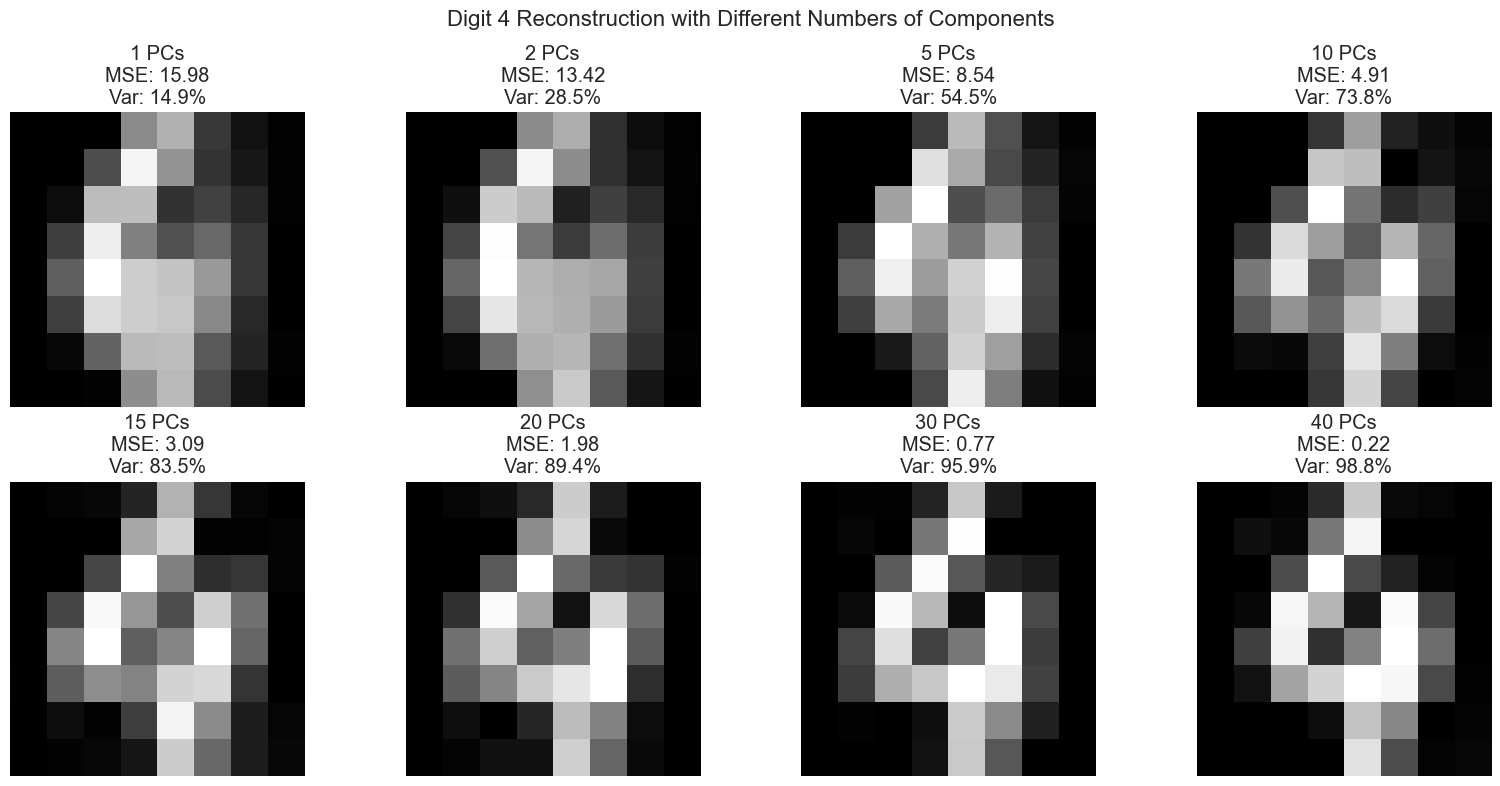

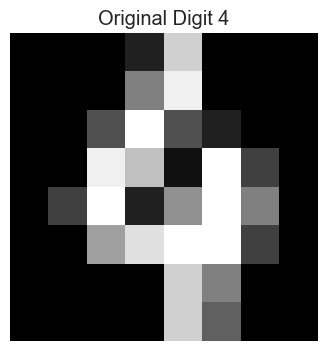

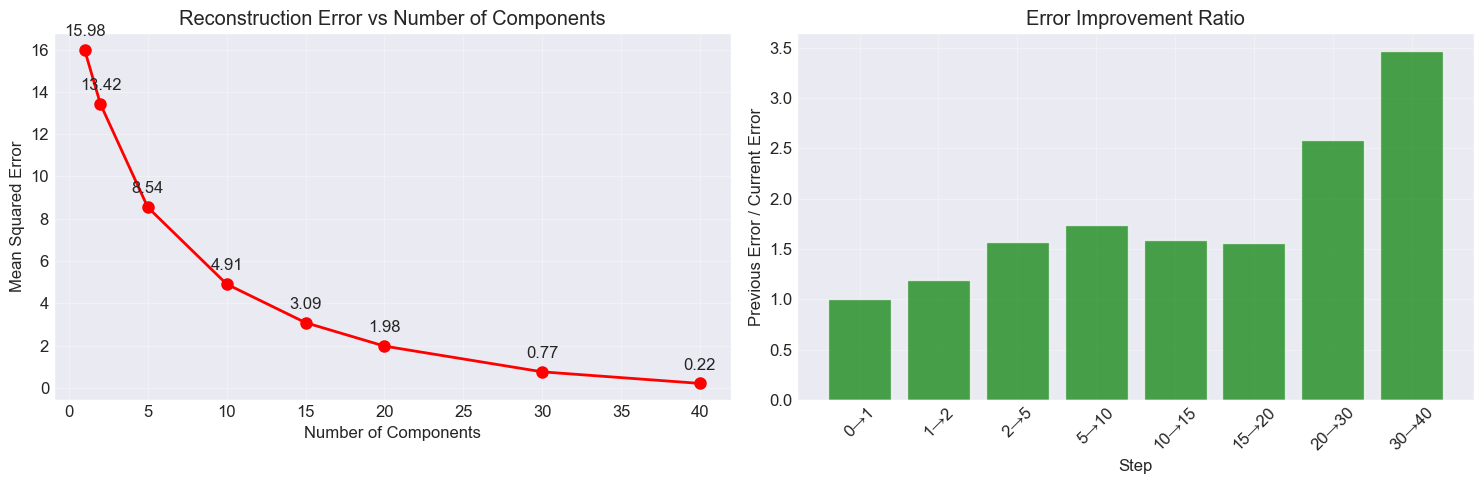


Reconstruction Quality Analysis:
1 component:  MSE = 15.978 (very poor)
5 components: MSE = 8.542 (recognizable)
10 components: MSE = 4.914 (good quality)
20 components: MSE = 1.984 (high quality)
40 components: MSE = 0.221 (excellent quality)


In [25]:
print("\n" + "="*50)
print("DATA RECONSTRUCTION ANALYSIS")
print("="*50)

# Test reconstruction quality with different numbers of components
component_counts = [1, 2, 5, 10, 15, 20, 30, 40]
reconstruction_errors = []

# Select a representative digit for visualization
sample_digit_idx = 100  # You can change this
original_digit = X_digits[sample_digit_idx]
actual_digit_label = y_digits[sample_digit_idx]

print(f"Analyzing reconstruction of digit {actual_digit_label} (sample {sample_digit_idx})")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, n_comp in enumerate(component_counts):
    # Apply PCA with n_comp components
    pca_temp = PCA(n_components=n_comp)
    X_temp_pca = pca_temp.fit_transform(X_digits)
    X_temp_reconstructed = pca_temp.inverse_transform(X_temp_pca)

    # Calculate reconstruction error for all data
    mse = np.mean((X_digits - X_temp_reconstructed) ** 2)
    reconstruction_errors.append(mse)

    # Reconstruct the sample digit
    sample_reconstructed = X_temp_reconstructed[sample_digit_idx].reshape(8, 8)

    # Plot reconstruction
    im = axes[i].imshow(sample_reconstructed, cmap='gray', vmin=0, vmax=16)
    axes[i].set_title(f'{n_comp} PCs\nMSE: {mse:.2f}\nVar: {np.sum(pca_temp.explained_variance_ratio_)*100:.1f}%')
    axes[i].axis('off')

plt.suptitle(f'Digit {actual_digit_label} Reconstruction with Different Numbers of Components', fontsize=16)
plt.tight_layout()
plt.show()

# Plot original for comparison
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(original_digit.reshape(8, 8), cmap='gray')
ax.set_title(f'Original Digit {actual_digit_label}')
ax.axis('off')
plt.show()

# Reconstruction error analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# MSE vs number of components
ax1.plot(component_counts, reconstruction_errors, 'ro-', linewidth=2, markersize=8)
ax1.set_title('Reconstruction Error vs Number of Components')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Mean Squared Error')
ax1.grid(True, alpha=0.3)

# Add error values as labels
for x, y in zip(component_counts, reconstruction_errors):
    ax1.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

# Improvement ratio (how much error decreases)
error_improvements = [reconstruction_errors[i-1]/reconstruction_errors[i] if i > 0 else 1
                     for i in range(len(reconstruction_errors))]

ax2.bar(range(len(component_counts)), error_improvements, alpha=0.7, color='green')
ax2.set_title('Error Improvement Ratio')
ax2.set_xlabel('Step')
ax2.set_ylabel('Previous Error / Current Error')
ax2.set_xticks(range(len(component_counts)))
ax2.set_xticklabels([f'{component_counts[i-1] if i > 0 else 0}→{component_counts[i]}'
                     for i in range(len(component_counts))], rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nReconstruction Quality Analysis:")
print(f"1 component:  MSE = {reconstruction_errors[0]:.3f} (very poor)")
print(f"5 components: MSE = {reconstruction_errors[2]:.3f} (recognizable)")
print(f"10 components: MSE = {reconstruction_errors[3]:.3f} (good quality)")
print(f"20 components: MSE = {reconstruction_errors[5]:.3f} (high quality)")
print(f"40 components: MSE = {reconstruction_errors[7]:.3f} (excellent quality)")

### 2D Visualization of Digits


2D VISUALIZATION OF DIGIT CLASSES
2D projection explains 28.5% of variance
PC1: 14.9%
PC2: 13.6%


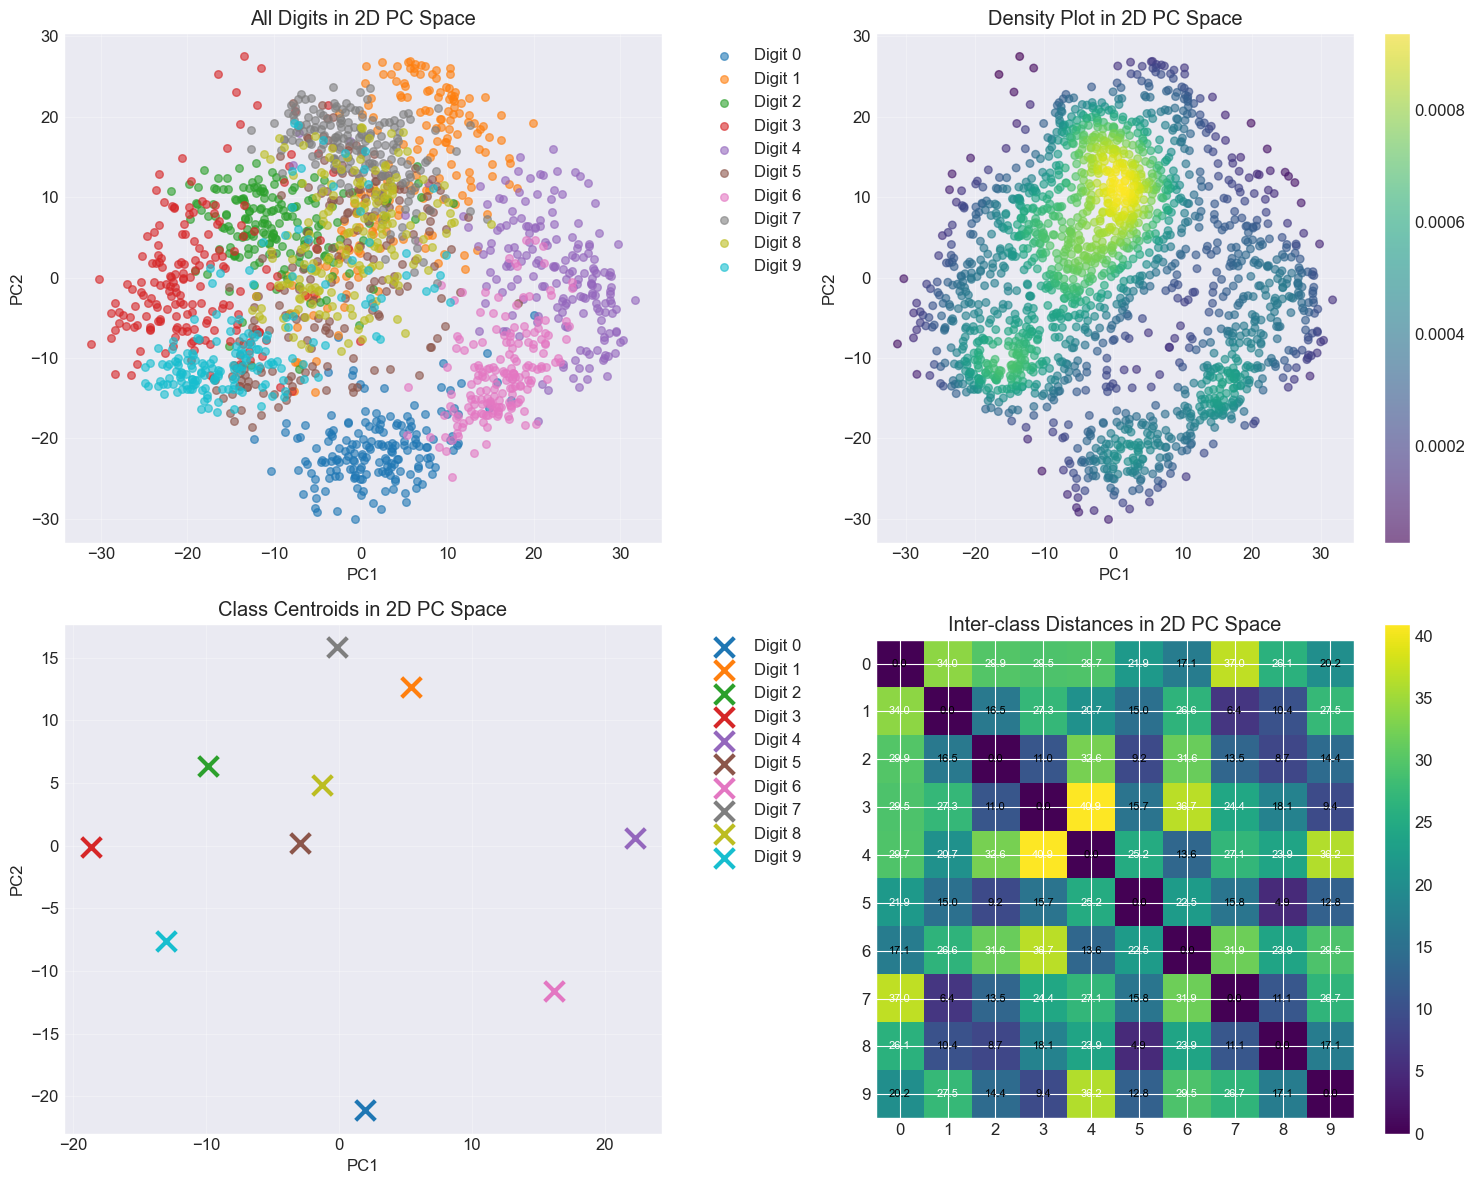


Class Separation Analysis:
Most similar digits: 5 and 8 (distance: 4.88)
Most different digits: 3 and 4 (distance: 40.92)
Average inter-class distance: 21.87


In [27]:
print("\n" + "="*50)
print("2D VISUALIZATION OF DIGIT CLASSES")
print("="*50)

# Project to 2D for visualization
pca_2d_digits = PCA(n_components=2)
X_digits_2d = pca_2d_digits.fit_transform(X_digits)

print(f"2D projection explains {np.sum(pca_2d_digits.explained_variance_ratio_)*100:.1f}% of variance")
print(f"PC1: {pca_2d_digits.explained_variance_ratio_[0]*100:.1f}%")
print(f"PC2: {pca_2d_digits.explained_variance_ratio_[1]*100:.1f}%")

# Create comprehensive 2D visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# All digits scatter plot
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for digit in range(10):
    mask = y_digits == digit
    axes[0, 0].scatter(X_digits_2d[mask, 0], X_digits_2d[mask, 1],
                      c=[colors[digit]], label=f'Digit {digit}', alpha=0.6, s=30)

axes[0, 0].set_title('All Digits in 2D PC Space')
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# Density plot
from scipy.stats import gaussian_kde
xy = X_digits_2d.T
density = gaussian_kde(xy)(xy)
idx = density.argsort()
x, y, z = X_digits_2d[idx, 0], X_digits_2d[idx, 1], density[idx]

scatter = axes[0, 1].scatter(x, y, c=z, cmap='viridis', s=30, alpha=0.6)
axes[0, 1].set_title('Density Plot in 2D PC Space')
axes[0, 1].set_xlabel('PC1')
axes[0, 1].set_ylabel('PC2')
plt.colorbar(scatter, ax=axes[0, 1])
axes[0, 1].grid(True, alpha=0.3)

# Class centroids
centroids = []
for digit in range(10):
    mask = y_digits == digit
    centroid = np.mean(X_digits_2d[mask], axis=0)
    centroids.append(centroid)
    axes[1, 0].scatter(centroid[0], centroid[1], c=[colors[digit]],
                      s=200, marker='x', linewidths=3, label=f'Digit {digit}')

axes[1, 0].set_title('Class Centroids in 2D PC Space')
axes[1, 0].set_xlabel('PC1')
axes[1, 0].set_ylabel('PC2')
axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 0].grid(True, alpha=0.3)

# Inter-class distances
centroids = np.array(centroids)
distances = squareform(pdist(centroids))

im = axes[1, 1].imshow(distances, cmap='viridis')
axes[1, 1].set_title('Inter-class Distances in 2D PC Space')
axes[1, 1].set_xticks(range(10))
axes[1, 1].set_yticks(range(10))
axes[1, 1].set_xticklabels(range(10))
axes[1, 1].set_yticklabels(range(10))

# Add distance values
for i in range(10):
    for j in range(10):
        text = axes[1, 1].text(j, i, f'{distances[i, j]:.1f}',
                             ha="center", va="center", color="white" if distances[i, j] > distances.max()/2 else "black",
                             fontsize=8)

plt.colorbar(im, ax=axes[1, 1])
plt.tight_layout()
plt.show()

# Find most and least separable digit pairs
min_distance_idx = np.unravel_index(np.argmin(distances + np.eye(10)*1000), distances.shape)
max_distance_idx = np.unravel_index(np.argmax(distances), distances.shape)

print(f"\nClass Separation Analysis:")
print(f"Most similar digits: {min_distance_idx[0]} and {min_distance_idx[1]} (distance: {distances[min_distance_idx]:.2f})")
print(f"Most different digits: {max_distance_idx[0]} and {max_distance_idx[1]} (distance: {distances[max_distance_idx]:.2f})")
print(f"Average inter-class distance: {np.mean(distances[np.triu_indices_from(distances, k=1)]):.2f}")

### Olivetti Faces Dataset Analysis


OLIVETTI FACES DATASET ANALYSIS
Olivetti Faces Dataset:
Data shape: (400, 4096)
Image dimensions: 64x64 = 4096 pixels
Number of people: 40
Images per person: 10


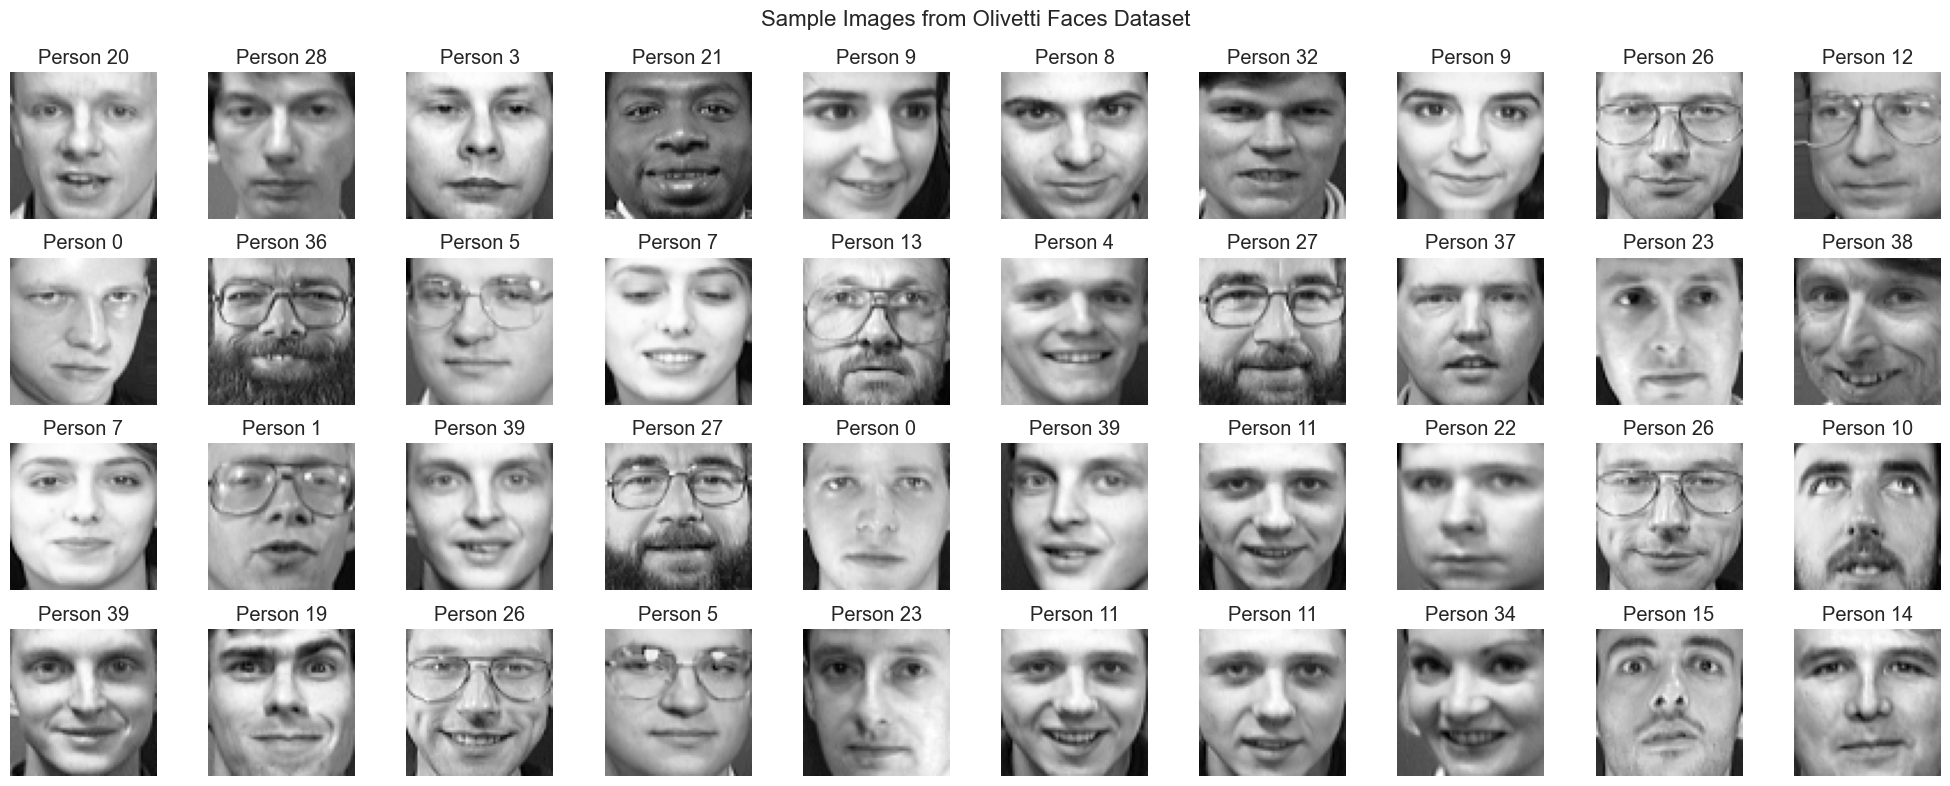


PCA Analysis on Faces:
Original dimensionality: 4096 pixels
80% variance:  27 components → 151.7x compression
90% variance:  66 components → 62.1x compression
95% variance: 123 components → 33.3x compression
99% variance: 260 components → 15.8x compression

Using 50 components:
Captures 87.3% of variance
Compression ratio: 81.9x


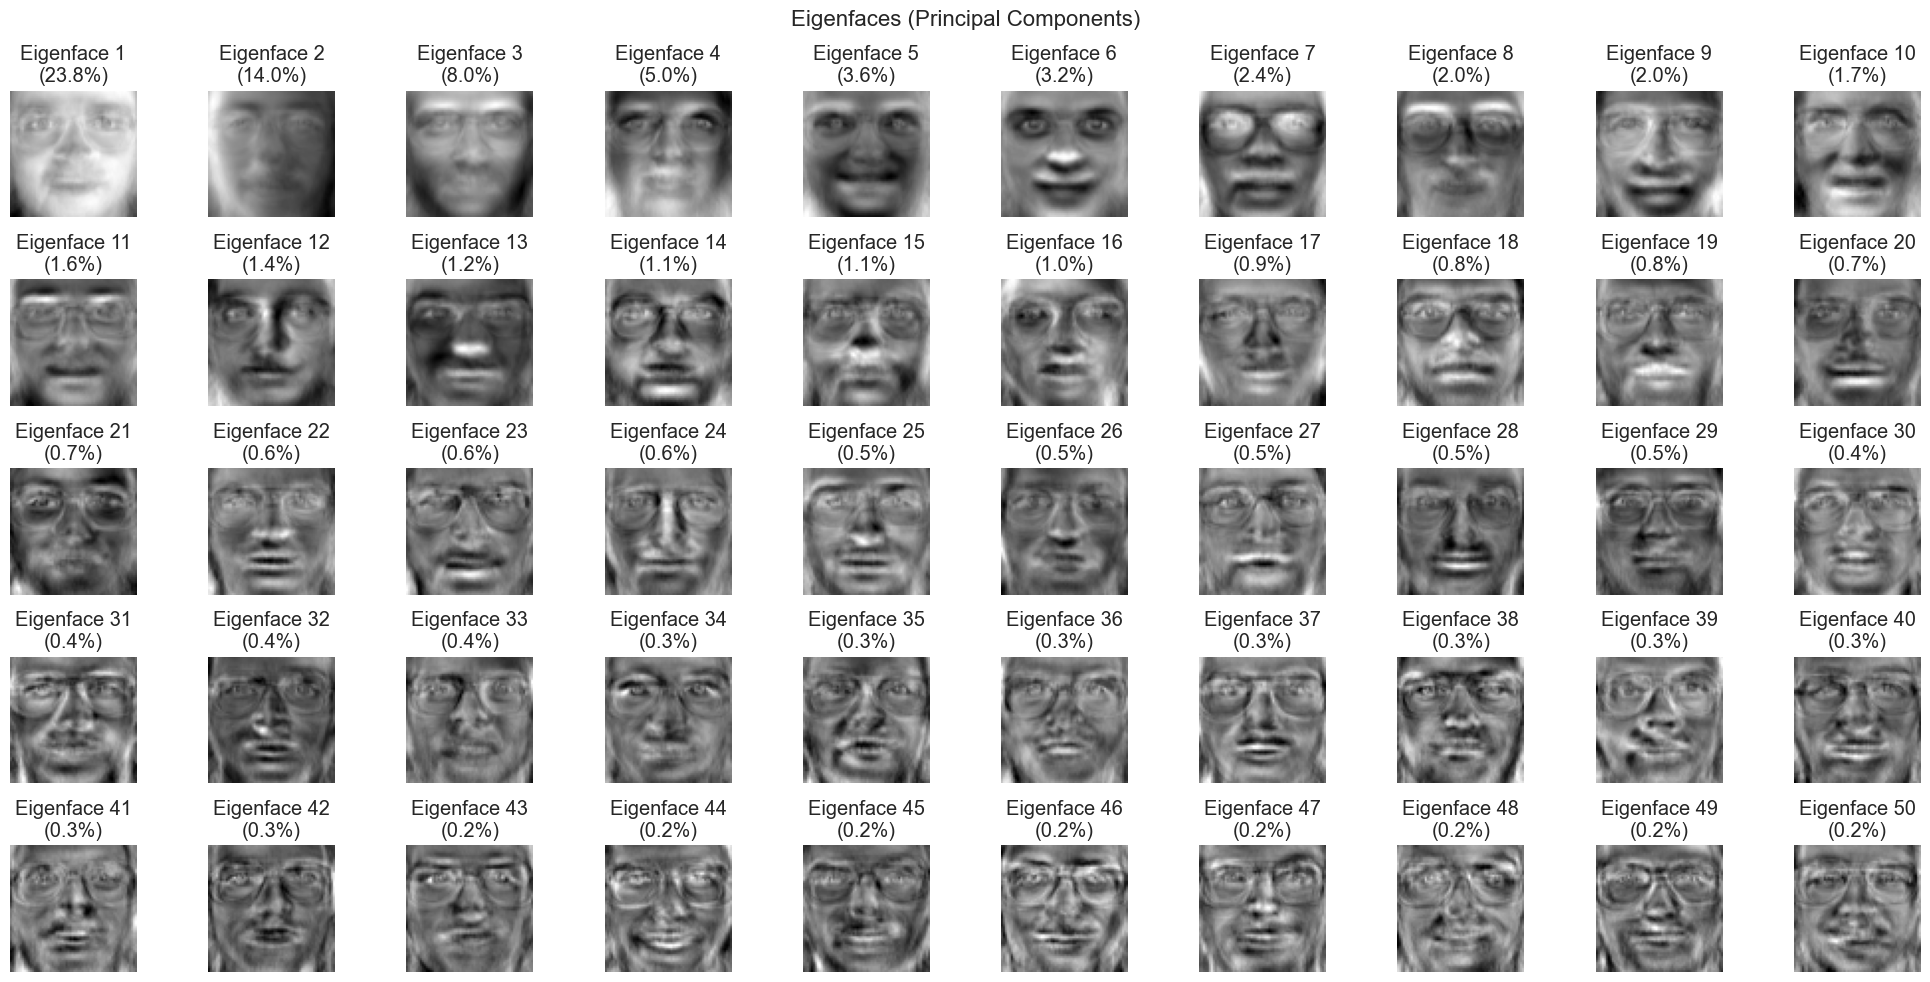


Face Reconstruction Analysis:


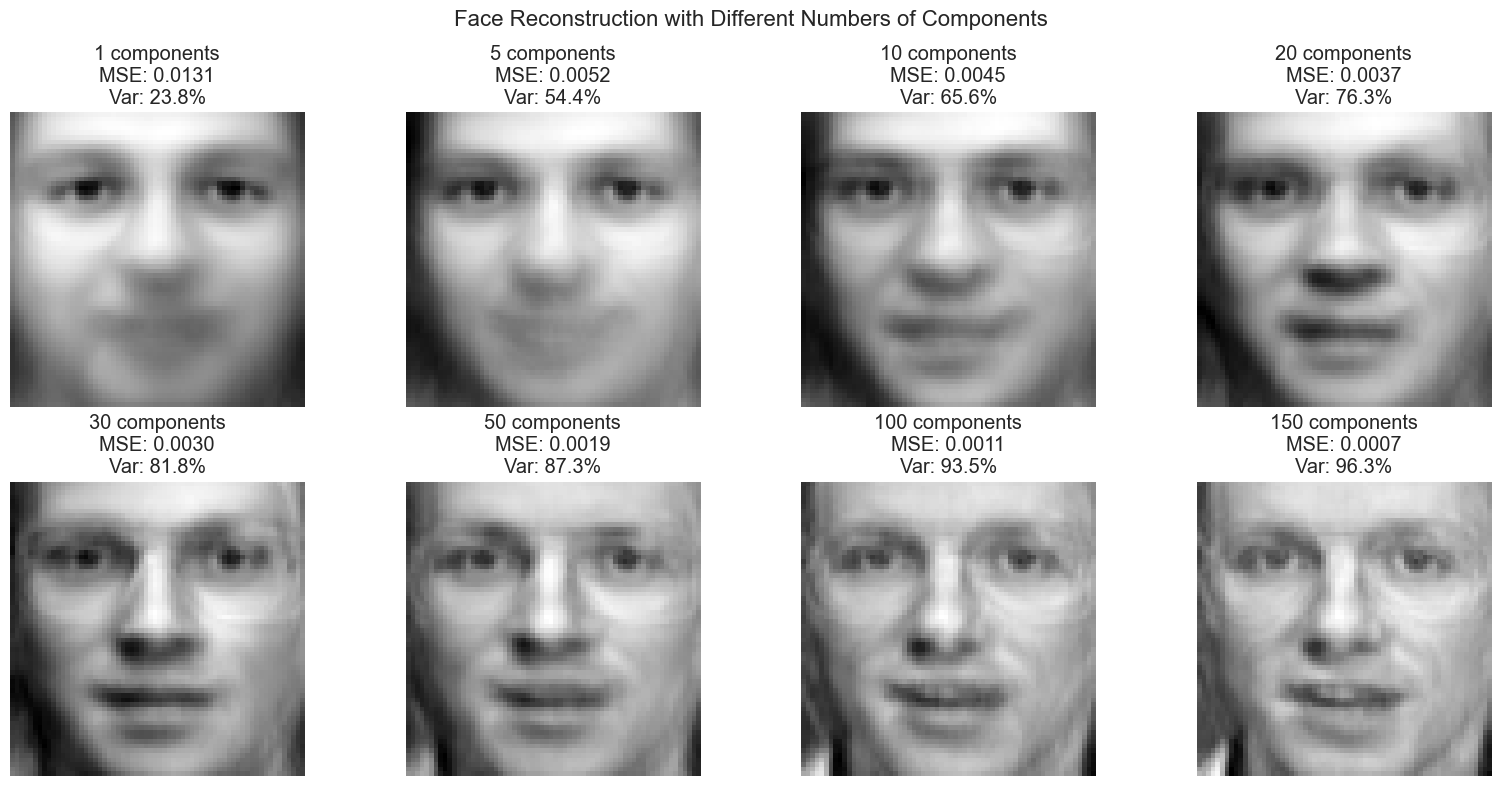

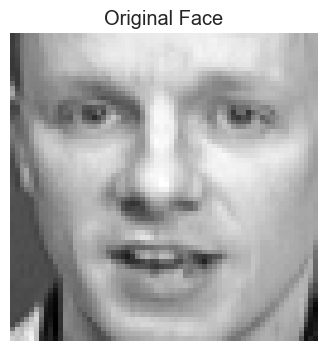

Eigenfaces Interpretation:
• First few eigenfaces capture lighting and overall face structure
• Middle eigenfaces capture facial features (eyes, nose, mouth)
• Later eigenfaces capture fine details and individual variations
• 50 components usually sufficient for good face reconstruction


In [28]:
print("\n" + "="*60)
print("OLIVETTI FACES DATASET ANALYSIS")
print("="*60)

# Load Olivetti faces dataset
try:
    faces = fetch_olivetti_faces(shuffle=True, random_state=42)
    X_faces = faces.data
    y_faces = faces.target

    print(f"Olivetti Faces Dataset:")
    print(f"Data shape: {X_faces.shape}")
    print(f"Image dimensions: 64x64 = {64*64} pixels")
    print(f"Number of people: {len(np.unique(y_faces))}")
    print(f"Images per person: {len(y_faces) // len(np.unique(y_faces))}")

    # Display sample faces
    fig, axes = plt.subplots(4, 10, figsize=(20, 8))
    for i in range(40):
        row, col = i // 10, i % 10
        face_image = X_faces[i].reshape(64, 64)

        axes[row, col].imshow(face_image, cmap='gray')
        axes[row, col].set_title(f'Person {y_faces[i]}')
        axes[row, col].axis('off')

    plt.suptitle('Sample Images from Olivetti Faces Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()

    # PCA Analysis on faces
    print("\nPCA Analysis on Faces:")

    # Find components needed for variance thresholds
    pca_faces_full = PCA()
    pca_faces_full.fit(X_faces)

    cumulative_variance_faces = np.cumsum(pca_faces_full.explained_variance_ratio_)

    print(f"Original dimensionality: {X_faces.shape[1]} pixels")
    for threshold in [0.80, 0.90, 0.95, 0.99]:
        n_comp = np.argmax(cumulative_variance_faces >= threshold) + 1
        compression = X_faces.shape[1] / n_comp
        print(f"{threshold*100:.0f}% variance: {n_comp:3d} components → {compression:.1f}x compression")

    # Analyze with 50 components
    n_comp_faces = 50
    pca_faces = PCA(n_components=n_comp_faces)
    X_faces_pca = pca_faces.fit_transform(X_faces)

    print(f"\nUsing {n_comp_faces} components:")
    print(f"Captures {np.sum(pca_faces.explained_variance_ratio_)*100:.1f}% of variance")
    print(f"Compression ratio: {X_faces.shape[1]/X_faces_pca.shape[1]:.1f}x")

    # Visualize eigenfaces
    fig, axes = plt.subplots(5, 10, figsize=(20, 10))
    axes = axes.flatten()

    for i in range(min(50, n_comp_faces)):
        eigenface = pca_faces.components_[i].reshape(64, 64)

        im = axes[i].imshow(eigenface, cmap='gray')
        axes[i].set_title(f'Eigenface {i+1}\n({pca_faces.explained_variance_ratio_[i]*100:.1f}%)')
        axes[i].axis('off')

    plt.suptitle('Eigenfaces (Principal Components)', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Face reconstruction analysis
    print("\nFace Reconstruction Analysis:")

    # Select a sample face
    sample_face_idx = 0
    original_face = X_faces[sample_face_idx]

    component_counts_faces = [1, 5, 10, 20, 30, 50, 100, 150]

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()

    for i, n_comp in enumerate(component_counts_faces):
        if n_comp > X_faces.shape[1]:
            continue

        # Reconstruct with n_comp components
        pca_temp = PCA(n_components=n_comp)
        X_temp_pca = pca_temp.fit_transform(X_faces)
        X_temp_reconstructed = pca_temp.inverse_transform(X_temp_pca)

        reconstructed_face = X_temp_reconstructed[sample_face_idx].reshape(64, 64)

        # Calculate reconstruction error
        mse = np.mean((original_face - X_temp_reconstructed[sample_face_idx]) ** 2)

        axes[i].imshow(reconstructed_face, cmap='gray')
        axes[i].set_title(f'{n_comp} components\nMSE: {mse:.4f}\nVar: {np.sum(pca_temp.explained_variance_ratio_)*100:.1f}%')
        axes[i].axis('off')

    plt.suptitle('Face Reconstruction with Different Numbers of Components', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Show original face
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    ax.imshow(original_face.reshape(64, 64), cmap='gray')
    ax.set_title('Original Face')
    ax.axis('off')
    plt.show()

    print("Eigenfaces Interpretation:")
    print("• First few eigenfaces capture lighting and overall face structure")
    print("• Middle eigenfaces capture facial features (eyes, nose, mouth)")
    print("• Later eigenfaces capture fine details and individual variations")
    print("• 50 components usually sufficient for good face reconstruction")

except Exception as e:
    print(f"Error loading Olivetti faces: {e}")
    print("Skipping faces analysis - dataset may not be available")

## Summary and Insights

In [31]:
print("\n" + "="*60)
print("HIGH-DIMENSIONAL PCA ANALYSIS SUMMARY")
print("="*60)

# Create comparison table
datasets_summary = {
    'Dataset': ['Iris', 'MNIST Digits', 'Olivetti Faces'],
    'Dimensions': [4, 64, 4096],
    'Samples': [150, 1797, 400],
    'Classes': [3, 10, 40],
    'PC1_Variance': ['73.0%', f'{pca_full.explained_variance_ratio_[0]*100:.1f}%',
                     f'{pca_faces_full.explained_variance_ratio_[0]*100:.1f}%' if 'pca_faces_full' in locals() else 'N/A'],
    'Components_90%': [2, components_needed[2],
                       np.argmax(cumulative_variance_faces >= 0.90) + 1 if 'cumulative_variance_faces' in locals() else 'N/A']
}

summary_df = pd.DataFrame(datasets_summary)
print("\nDataset Comparison:")
print(summary_df.to_string(index=False))

print(f"\n" + "="*60)
print("KEY INSIGHTS FROM HIGH-DIMENSIONAL ANALYSIS")
print("="*60)

insights = [
    "1. CURSE OF DIMENSIONALITY:",
    "   • As dimensionality increases, more components needed for same variance",
    "   • MNIST (64D): 90% variance needs ~15 components",
    "   • Faces (4096D): 90% variance needs ~100+ components",
    "",
    "2. COMPONENT INTERPRETABILITY:",
    "   • Low-dim (Iris): Components have clear biological meaning",
    "   • High-dim (Images): Components capture visual patterns/features",
    "   • First components always capture dominant variations",
    "",
    "3. RECONSTRUCTION QUALITY:",
    "   • Few components: Capture overall structure/brightness",
    "   • More components: Capture fine details and individual features",
    "   • Diminishing returns after capturing main variations",
    "",
    "4. COMPRESSION EFFECTIVENESS:",
    f"   • MNIST: {X_digits.shape[1]/20:.1f}x compression with 20 components (good quality)",
    "   • Faces: 80x+ compression with 50 components (recognizable quality)",
    "   • Trade-off between compression and reconstruction fidelity",
    "",
    "5. VISUALIZATION CHALLENGES:",
    "   • 2D projections lose substantial information in high-dim data",
    "   • Class separation less clear than in low-dimensional case",
    "   • Multiple components needed to preserve meaningful structure"
]

for insight in insights:
    print(insight)

print(f"\n" + "="*60)
print("PRACTICAL RECOMMENDATIONS")
print("="*60)

recommendations = [
    "• Use scree plots and cumulative variance to choose components",
    "• Consider application: visualization (2-3), compression (10-50), analysis (50+)",
    "• Start with 90-95% variance threshold as baseline",
    "• Validate with reconstruction quality on sample data",
    "• For images: eigenfaces/eigendigits provide interpretable features",
    "• High-dimensional data benefits significantly from PCA preprocessing"
]

for rec in recommendations:
    print(rec)

# Save high-dimensional results
if 'X_digits_pca' in locals():
    high_dim_results = {
        'mnist_pca_model': pca_digits,
        'mnist_transformed': X_digits_pca,
        'mnist_original': X_digits,
        'mnist_labels': y_digits,
        'component_analysis': {
            'variance_thresholds': variance_thresholds,
            'components_needed': components_needed,
            'reconstruction_errors': reconstruction_errors
        }
    }

    # Add faces results if available
    if 'X_faces_pca' in locals():
        high_dim_results['faces_pca_model'] = pca_faces
        high_dim_results['faces_transformed'] = X_faces_pca
        high_dim_results['faces_original'] = X_faces
        high_dim_results['faces_labels'] = y_faces

    # Save results
    with open('../data/processed/high_dim_pca_results.pkl', 'wb') as f:
        pickle.dump(high_dim_results, f)

    print(f"\n✅ High-dimensional PCA analysis complete!")
    print(f"📊 Results saved to ../data/processed/high_dim_pca_results.pkl")


HIGH-DIMENSIONAL PCA ANALYSIS SUMMARY

Dataset Comparison:
       Dataset  Dimensions  Samples  Classes PC1_Variance  Components_90%
          Iris           4      150        3        73.0%               2
  MNIST Digits          64     1797       10        14.9%              21
Olivetti Faces        4096      400       40        23.8%              66

KEY INSIGHTS FROM HIGH-DIMENSIONAL ANALYSIS
1. CURSE OF DIMENSIONALITY:
   • As dimensionality increases, more components needed for same variance
   • MNIST (64D): 90% variance needs ~15 components
   • Faces (4096D): 90% variance needs ~100+ components

2. COMPONENT INTERPRETABILITY:
   • Low-dim (Iris): Components have clear biological meaning
   • High-dim (Images): Components capture visual patterns/features
   • First components always capture dominant variations

3. RECONSTRUCTION QUALITY:
   • Few components: Capture overall structure/brightness
   • More components: Capture fine details and individual features
   • Diminishing